In [1569]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


! if [ ! -d /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis/ ]; then mkdir /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis; fi

os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [1570]:
def quantileNormalize(vals1, vals2):
    '''
    input: two scalar arrays
    output: two quantile normalized scalar arrays
    '''
    vals1 = np.array(vals1)
    vals2 = np.array(vals2)
    
    ranks_1 = scipy.stats.rankdata(vals1, method = 'dense')
    ranks_2 = scipy.stats.rankdata(vals2, method = 'dense')
    
    sorted_vals_1 = sorted(vals1)
    sorted_vals_2 = sorted(vals2)
    means = np.mean([sorted_vals_1,sorted_vals_2], axis=0)
    
    rank_mean_dict = dict(zip(sorted(ranks_1), sorted(means)))
    normalized_vals_1 = np.array([rank_mean_dict[x] for x in ranks_1])
    normalized_vals_2 = np.array([rank_mean_dict[x] for x in ranks_2])
    return normalized_vals_1, normalized_vals_2

def calcMAD(vals):
    '''
    inputs: an array of scalars
    output: median absolute deviation of input array
    Calculates MAD, the median of the absolute values 
    of the differences between the data values and the 
    overall median of the data set
    '''
    overall_median = np.median(vals)
    absolute_distances = [abs(x-overall_median) for x in vals]
    mad = np.median(absolute_distances)
    return mad

def medNormalize(vals1, vals2):
    med_1 = np.median(vals1)
    med_2 = np.median(vals2)
    if med_1 > med_2:
        corrected_vals1 = vals1
        corrected_vals2 = vals2 + (med-1 - med_2)
    else:
        corrected_vals1 = vehicle_vals+ (med_2 - med_1)
        corrected_vals2 = treated_vals
    return corrected_vals1, corrected_vals2

## Copy Files

In [1721]:
%%bash
# get differentially expressed gene files
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/homer_diffExpresion.tsv ./human_diffExpression.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/homer_diffExpresion.tsv ./mouse_diffExpression.tsv

# get IDR scores
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_Des_idrUnion.tsv ./mouse_des_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_DMHCA_idrUnion.tsv ./mouse_dmhca_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_T09_idrUnion.tsv ./mouse_t09_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_GW_idrUnion.tsv ./mouse_gw_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_Mepip_idrUnion.tsv ./mouse_mepip_idrUnion.tsv


cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_Des_idrUnion.tsv ./human_des_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_DMHCA_idrUnion.tsv ./human_dhmca_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_T09_idrUnion.tsv ./human_t09_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_GW_idrUnion.tsv ./human_gw_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_Mepip_idrUnion.tsv ./human_mepip_idrUnion.tsv


# get rpkm values
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/rpkm.tsv ./mouse_rpkm.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/rpkm.tsv ./human_rpkm.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/raw.tsv ./mouse_reads.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/raw.tsv ./human_reads.tsv


## Identify mouse human homologs

In [275]:
# download homolog file
! wget ftp://ftp.informatics.jax.org/pub/reports/HOM_MouseHumanSequence.rpt

--2016-08-01 09:56:57--  ftp://ftp.informatics.jax.org/pub/reports/HOM_MouseHumanSequence.rpt
           => ‘HOM_MouseHumanSequence.rpt’
Resolving ftp.informatics.jax.org (ftp.informatics.jax.org)... 64.147.54.33
Connecting to ftp.informatics.jax.org (ftp.informatics.jax.org)|64.147.54.33|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/reports ... done.
==> SIZE HOM_MouseHumanSequence.rpt ... 7596152
==> PASV ... done.    ==> RETR HOM_MouseHumanSequence.rpt ... done.
Length: 7596152 (7.2M) (unauthoritative)

100%[======================================>] 7,596,152   4.04MB/s   in 1.8s   

2016-08-01 09:57:00 (4.04 MB/s) - ‘HOM_MouseHumanSequence.rpt’ saved [7596152]



In [1572]:
homolog_frame = pd.read_csv('./HOM_MouseHumanSequence.rpt', sep='\t')

In [1573]:
mouse_homolog_genes = set()
human_homolog_genes = set()
current_frame = homolog_frame[homolog_frame['Common Organism Name'] == 'mouse, laboratory']

homoloGeneID_mouseGene_dict = dict(zip(current_frame['HomoloGene ID'].values, 
                                current_frame['Symbol'].values))

current_frame = homolog_frame[homolog_frame['Common Organism Name'] == 'human']

homoloGeneID_humanGene_dict = dict(zip(current_frame['HomoloGene ID'].values, 
                                current_frame['Symbol'].values))

mouse_human_homologMapping = {}
human_mouse_homologMapping = {}
count = 0
for key in homoloGeneID_humanGene_dict:
    if key in homoloGeneID_humanGene_dict and key in homoloGeneID_mouseGene_dict:
        mouse_gene = homoloGeneID_mouseGene_dict[key].upper()
        human_gene = homoloGeneID_humanGene_dict[key].upper()

        mouse_human_homologMapping[mouse_gene] = human_gene
        human_mouse_homologMapping[human_gene] = mouse_gene
        
        mouse_homolog_genes.add(mouse_gene)
        human_homolog_genes.add(human_gene)
    else:
        count+=1
print(count)

1951


### Read in RNA-seq Data

In [1574]:
# read in human rpkm values
rpkm_human_frame = pd.read_csv('./human_rpkm.tsv', sep='\t')
columns = rpkm_human_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
        tokens = columns[i].split('_')
        columns[i] = tokens[2] + '_' + tokens[0].split('-')[-1]
rpkm_human_frame.columns = columns    
rpkm_human_frame['gene'] = [x.split("|")[0].upper() for x in rpkm_human_frame['Annotation/Divergence']]
columns = list(rpkm_human_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_human_frame = rpkm_human_frame[columns]
rpkm_human_frame.index = rpkm_human_frame['gene'].values

# read in mouse rpkm values
rpkm_mouse_frame = pd.read_csv('./mouse_rpkm.tsv', sep='\t')
columns = rpkm_mouse_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
        tokens =  columns[i].split('_')[2].split('-')
        columns[i] = tokens[0] + '_' + tokens[1]
        
rpkm_mouse_frame.columns = columns    
rpkm_mouse_frame['gene'] = [x.split("|")[0].upper() for x in rpkm_mouse_frame['Annotation/Divergence']]
columns = list(rpkm_mouse_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_mouse_frame = rpkm_mouse_frame[columns]
rpkm_mouse_frame = rpkm_mouse_frame[rpkm_mouse_frame['gene'].isin(mouse_homolog_genes)]
rpkm_mouse_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping
                            else x
                            for x in rpkm_mouse_frame['gene'].values]
rpkm_mouse_frame.index = rpkm_mouse_frame['gene'].values

In [1575]:
reads_human_frame = pd.read_csv('./human_reads.tsv', sep='\t')
columns = reads_human_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
        tokens = columns[i].split('_')
        columns[i] = tokens[2] + '_' + tokens[0].split('-')[-1]
reads_human_frame.columns = columns    
reads_human_frame['gene'] = [x.split("|")[0].upper() for x in reads_human_frame['Annotation/Divergence']]
columns = list(reads_human_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_human_frame = reads_human_frame[columns]
reads_human_frame.index = reads_human_frame['gene'].values

reads_mouse_frame = pd.read_csv('./mouse_reads.tsv', sep='\t')
columns = reads_mouse_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
        tokens =  columns[i].split('_')[2].split('-')
        columns[i] = tokens[0] + '_' + tokens[1]
reads_mouse_frame.columns = columns    
reads_mouse_frame['gene'] = [x.split("|")[0].upper() for x in reads_mouse_frame['Annotation/Divergence']]
columns = list(reads_mouse_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_mouse_frame = reads_mouse_frame[columns]
reads_mouse_frame = reads_mouse_frame[reads_mouse_frame['gene'].isin(mouse_homolog_genes)]
reads_mouse_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping
                            else x
                            for x in reads_mouse_frame['gene'].values]
reads_mouse_frame.index = reads_mouse_frame['gene'].values

In [1576]:
### filter away genes that are expressed at less than 4 rpkm
rpkm_threshold = 4

rpkm_human_frame = rpkm_human_frame[rpkm_human_frame.ix[:,9:].max(axis=1) >= rpkm_threshold]
rpkm_mouse_frame = rpkm_mouse_frame[rpkm_mouse_frame.ix[:,9:].max(axis=1) >= rpkm_threshold]

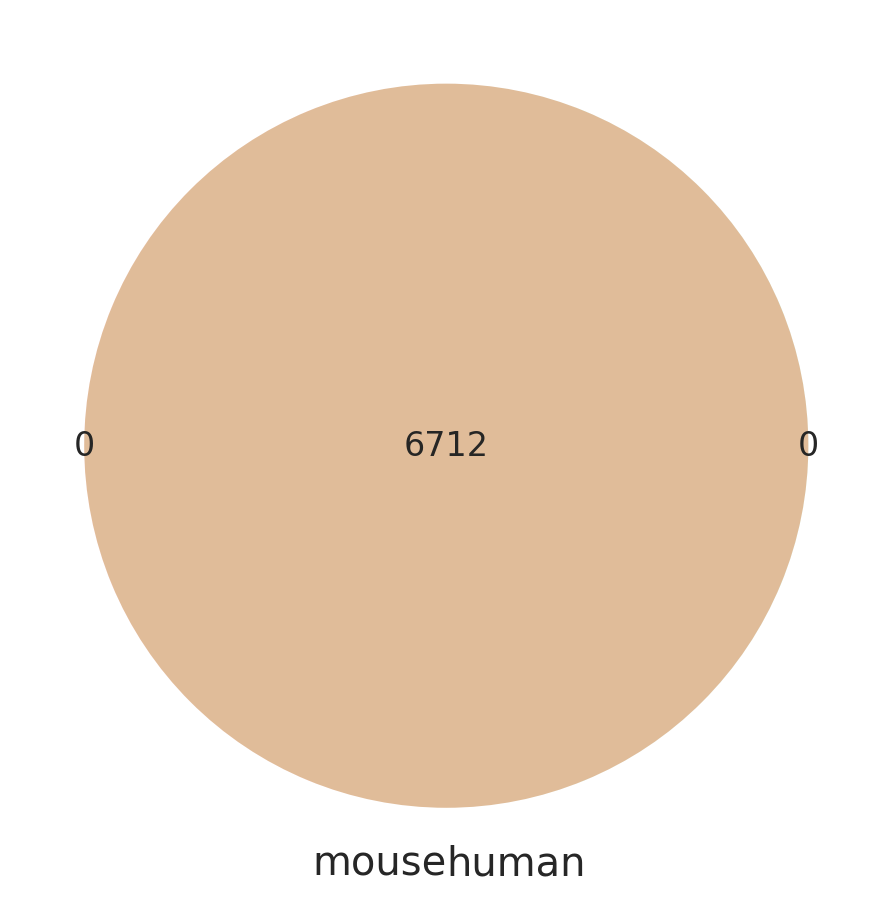

In [1577]:
### use only genes that appear in both human and mouse
intersecting_genes = set(rpkm_mouse_frame.index.values).intersection(set(rpkm_human_frame.index.values))

rpkm_mouse_frame = rpkm_mouse_frame[rpkm_mouse_frame.index.isin(intersecting_genes)]
rpkm_human_frame = rpkm_human_frame[rpkm_human_frame.index.isin(intersecting_genes)]

reads_mouse_frame = reads_mouse_frame[reads_mouse_frame.index.isin(intersecting_genes)]
reads_human_frame = reads_human_frame[reads_human_frame.index.isin(intersecting_genes)]

matplotlib_venn.venn2([set(rpkm_mouse_frame.index.values),
 set(rpkm_human_frame.index.values)],
 ['mouse', 'human'])

## Integrate IDR Scores with EdgeR

In [1784]:
condition_significantGenes_dict = {}
condition_significantFrame_dict = {}

In [1803]:
### Read in EdgeR Values

# human
diffExpression_human_frame = pd.read_csv('human_diffExpression.tsv', sep='\t')
columns = diffExpression_human_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_human_frame.columns=columns
diffExpression_human_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_human_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_human_frame.columns if 'vs.' in x]
diffExpression_human_frame = diffExpression_human_frame[columns]
diffExpression_human_frame = diffExpression_human_frame[diffExpression_human_frame['gene'].isin(intersecting_genes)]
diffExpression_human_frame.index = diffExpression_human_frame.gene.values


# mouse
diffExpression_mouse_frame = pd.read_csv('mouse_diffExpression.tsv', sep='\t')
columns = diffExpression_mouse_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_mouse_frame.columns=columns
diffExpression_mouse_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_mouse_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_mouse_frame.columns if 'vs.' in x]
diffExpression_mouse_frame = diffExpression_mouse_frame[columns]
diffExpression_mouse_frame = diffExpression_mouse_frame[diffExpression_mouse_frame['gene'].isin(intersecting_genes)]
diffExpression_mouse_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping
                                      else x
                                      for x in diffExpression_mouse_frame['gene'].values]



diffExpression_mouse_frame.index = diffExpression_mouse_frame.gene.values



In [1807]:
### integrate mouse scores
treatments = ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']
p_threshold = 0.05
fold_threshold = np.log2(2)
for treatment in treatments:
    idr_frame = pd.read_csv('mouse_' + treatment.lower() + '_idrUnion.tsv', sep='\t')
    idr_frame['gene'] = [x.split('|')[0].upper() for x in idr_frame['annotation'].values]
    idr_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in idr_frame['gene']]
    idr_frame.index = idr_frame['gene'].values
    significant_frame = diffExpression_mouse_frame[
                            (diffExpression_mouse_frame[treatment + ' vs. Vehicle adj. p-value'] < p_threshold) &
                            (diffExpression_mouse_frame[treatment + ' vs. Vehicle Log2 Fold Change'].abs() > fold_threshold) &
                            (diffExpression_mouse_frame.index.isin(idr_frame.index.values)) &
                            (diffExpression_mouse_frame.index.isin(human_homolog_genes))
                        ][['gene', 
                           treatment + ' vs. Vehicle adj. p-value', 
                           treatment + ' vs. Vehicle Log2 Fold Change']]

    significant_idr_frame = idr_frame[idr_frame.index.isin(significant_frame.index.values)]
    gene_idrScore_dict = dict(zip(significant_idr_frame.index.values, 
                                  [[int(y) for y in x.split(', ')] for x in significant_idr_frame['idrScore']]))
    idr_means = []
    idr_medians = []
    idr_mins = []
    idr_maxes = []
    count = 0
    for gene in significant_frame.index.values:
        idr_vals = gene_idrScore_dict[gene]
        idr_means.append(np.mean(idr_vals))
        idr_medians.append(np.median(idr_vals))
        idr_mins.append(np.min(idr_vals))
        idr_maxes.append(np.max(idr_vals))
        
#     significant_frame['IDR Min'] = idr_mins
    significant_frame['IDR Mean'] = idr_means
    significant_frame['IDR Median'] = idr_medians
#     significant_frame['IDR Max'] = idr_maxes
    significant_frame = significant_frame.sort(treatment + ' vs. Vehicle adj. p-value')
    # down regulated genes
    down_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] > 0]
    down_frame.to_csv('mouse_'+treatment+'_down_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['mouse_' + treatment.lower() + '_down'] = down_frame
    condition_significantGenes_dict['mouse_' + treatment.lower() + '_down'] = down_frame.index.values
    # upregulated genes
    up_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] < 0]
    up_frame.to_csv('mouse_'+treatment+'_up_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['mouse_' + treatment.lower() + '_up'] = up_frame
    condition_significantGenes_dict['mouse_' + treatment.lower() + '_up'] = up_frame.index.values

In [1808]:
### integrate human scores
treatments = ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']
p_threshold = 0.05
fold_threshold = np.log2(2)
for treatment in treatments:
    idr_frame = pd.read_csv('human_' + treatment.lower() + '_idrUnion.tsv', sep='\t')
    idr_frame['gene'] = [x.split('|')[0].upper() for x in idr_frame['annotation'].values]
    idr_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in idr_frame['gene']]
    idr_frame.index = idr_frame['gene'].values
    significant_frame = diffExpression_human_frame[
                            (diffExpression_human_frame[treatment + ' vs. Vehicle FDR'] < p_threshold) &
                            (diffExpression_human_frame[treatment + ' vs. Vehicle logFC'].abs() > fold_threshold) &
                            (diffExpression_human_frame.index.isin(idr_frame.index.values) &
                            (diffExpression_human_frame.index.isin(human_homolog_genes)))
                        ][['gene',
                           treatment + ' vs. Vehicle FDR', 
                           treatment + ' vs. Vehicle logFC']]
    
    significant_frame.columns = [x.replace('FDR', 'adj. p-value').replace('logFC', 'Log2 Fold Change')
                                 for x in significant_frame.columns.values]

    significant_idr_frame = idr_frame[idr_frame.index.isin(significant_frame.index.values)]
    gene_idrScore_dict = dict(zip(significant_idr_frame.index.values, 
                                  [[int(y) for y in x.split(', ')] for x in significant_idr_frame['idrScore']]))
    idr_means = []
    idr_medians = []
    idr_mins = []
    idr_maxes = []
    count = 0
    for gene in significant_frame.index.values:
        idr_vals = gene_idrScore_dict[gene]
        idr_means.append(np.mean(idr_vals))
        idr_medians.append(np.median(idr_vals))
        idr_mins.append(np.min(idr_vals))
        idr_maxes.append(np.max(idr_vals))
        
#     significant_frame['IDR Min'] = idr_mins
    significant_frame['IDR Mean'] = idr_means
    significant_frame['IDR Median'] = idr_medians
#     significant_frame['IDR Max'] = idr_maxes
    significant_frame = significant_frame.sort(treatment + ' vs. Vehicle adj. p-value')
    # down regulated genes
    down_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] > 0]
    down_frame.to_csv('human_'+treatment+'_down_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['human_' + treatment.lower() + '_down'] = down_frame
    condition_significantGenes_dict['human_' + treatment.lower() + '_down'] = down_frame.index.values
    # upregulated genes
    up_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] < 0]
    up_frame.to_csv('human_'+treatment+'_up_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['human_' + treatment.lower() + '_up'] = up_frame
    condition_significantGenes_dict['human_' + treatment.lower() + '_up'] = up_frame.index.values

## Variance Stuff

In [1809]:
### match samples and treatments

# for humans
sample_treatments = set()
sampleNames = set()
treatments = set()

treatment_sample_human_dict = {}
for sample in rpkm_human_frame.columns[9:]:
    tokens = sample.split('_')
    sampleName = tokens[1]
    treatment = tokens[0]
    sampleNames.add(sampleName)
    treatments.add(treatment)
    sample_treatments.add((sampleName,treatment))
    if treatment in treatment_sample_human_dict:
        treatment_sample_human_dict[treatment].append(sample)
    else:
        treatment_sample_human_dict[treatment] = [sample]
        
treatment_sample_bool_human_dict = {x:[] for x in treatments}
for sample in sorted(sampleNames):
    for treatment in sorted(treatments):
        if (sample, treatment) in sample_treatments:
            treatment_sample_bool_human_dict[treatment].append(True)
        else:
            treatment_sample_bool_human_dict[treatment].append(False)
treatment_sample_human_frame = pd.DataFrame(treatment_sample_bool_human_dict, columns=sorted(treatments), index=sorted(sampleNames))

# pick samples to use in heatmap
selected_human_samples = treatment_sample_human_frame[treatment_sample_human_frame[['Des', 'DMHCA', 'T09', 'Vehicle']].sum(axis=1) ==4][['Des', 'DMHCA', 'T09', 'Vehicle']].index.values

In [1810]:
# for mouse
sample_treatments = set()
sampleNames = set()
treatments = set()

treatment_sample_mouse_dict = {}
for sample in rpkm_mouse_frame.columns[9:]:
    tokens = sample.split('_')
    sampleName = tokens[1]
    treatment = tokens[0]
    sampleNames.add(sampleName)
    treatments.add(treatment)
    sample_treatments.add((sampleName,treatment))
    if treatment in treatment_sample_mouse_dict:
        treatment_sample_mouse_dict[treatment].append(sample)
    else:
        treatment_sample_mouse_dict[treatment] = [sample]
        
treatment_sample_bool_mouse_dict = {x:[] for x in treatments}
for sample in sorted(sampleNames):
    for treatment in sorted(treatments):
        if (sample, treatment) in sample_treatments:
            treatment_sample_bool_mouse_dict[treatment].append(True)
        else:
            treatment_sample_bool_mouse_dict[treatment].append(False)
treatment_sample_mouse_frame = pd.DataFrame(treatment_sample_bool_mouse_dict, columns=sorted(treatments), index=sorted(sampleNames))

In [1811]:
treatment_sample_human_frame

,DMHCA,Des,GW,Mepip,T09,Vehicle
006,True,True,False,True,True,True
008,False,True,True,True,True,True
012,True,True,True,False,True,True
013,True,False,True,True,True,True
015,True,True,False,True,True,True
021,True,True,True,False,True,True
024,True,True,True,True,True,False
038,True,True,True,True,True,True


In [1812]:
treatment_sample_mouse_frame

,DMHCA,Des,GW,Mepip,T09,Vehicle
1,True,True,True,True,True,True
2,True,True,True,True,True,True
3,True,True,True,True,True,True


### Variance Comparison

In [1813]:
### calculate median absolute deviation
genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
for treatment in sorted(treatment_sample_human_dict.keys()):
    human_samples = treatment_sample_human_dict[treatment]
    current_human_frame = rpkm_human_frame.ix[:, human_samples]
    
    mouse_samples = treatment_sample_mouse_dict[treatment]
    current_mouse_frame = rpkm_mouse_frame.ix[:, mouse_samples]
    
    current_human_mads = []
    current_mouse_mads = []
    for gene in genes:
        human_vals = current_human_frame.ix[gene, :].values
        mouse_vals = current_mouse_frame.ix[gene,:].values
        
        # calculate MAD
        human_mad = calcMAD(human_vals)
        mouse_mad = calcMAD(mouse_vals)
        
        current_human_mads.append(human_mad)
        current_mouse_mads.append(mouse_mad)
        
    column_vals_dict[treatment + ' human MAD'] = current_human_mads
    column_vals_dict[treatment + ' mouse MAD'] = current_mouse_mads

# create data frame
mad_frame = pd.DataFrame(column_vals_dict)
mad_frame.index = mad_frame['gene'].values
del mad_frame['gene']
mad_frame = mad_frame[sorted(mad_frame.columns.values)]
mad_frame = mad_frame.sort()

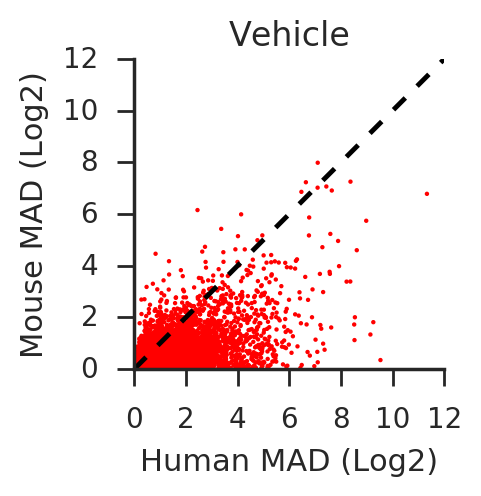

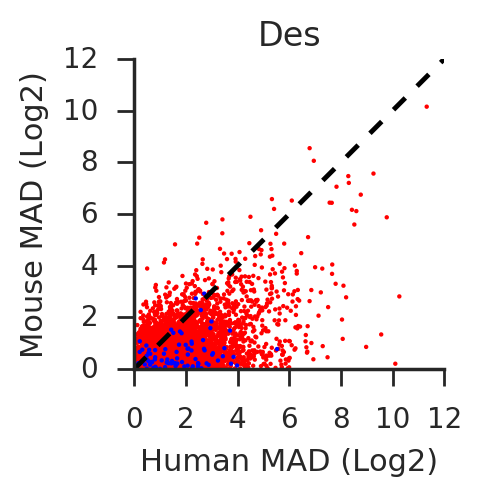

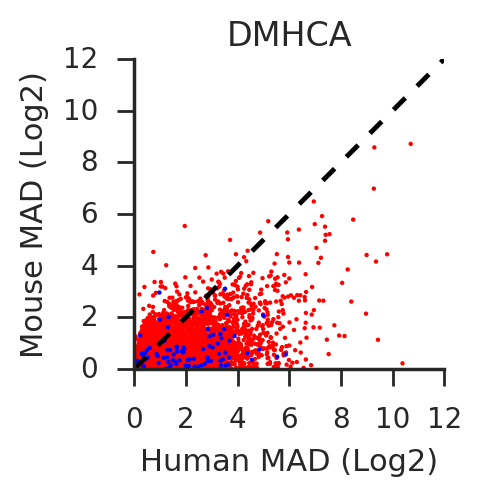

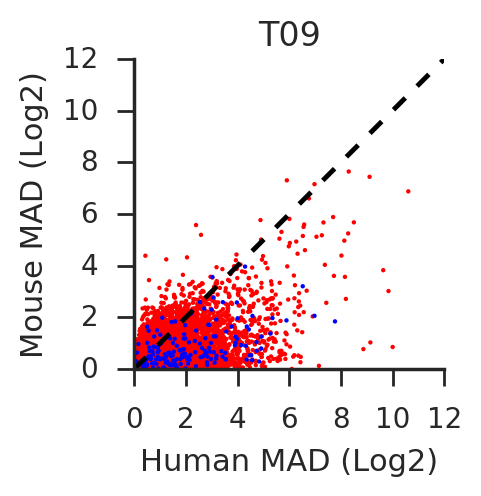

In [1814]:
genes = mad_frame.index.values
for treatment in ['Vehicle','Des', 'DMHCA', 'T09']:
    human_mads = mad_frame[treatment + ' human MAD'].values
    mouse_mads = mad_frame[treatment + ' mouse MAD'].values
    
    if not treatment == 'Vehicle':
        up_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']
        down_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']
        diff_genes = set(up_genes).union(down_genes)
    else:
        diff_genes = set()
    colors = ['blue' if x in diff_genes else 'red' for x in genes]
    
    tuples = zip(genes, human_mads, mouse_mads, colors)
    sorted_tuples = sorted(tuples, key=lambda x:x[3], reverse=True)
    sorted_genes = [x[0] for x in sorted_tuples]
    sorted_human_mads = np.array([x[1] for x in sorted_tuples])
    sorted_mouse_mads = np.array([x[2] for x in sorted_tuples])
    sorted_colors = [x[3] for x in sorted_tuples]
    
    with sns.axes_style('ticks'):
        plt.figure(figsize=(2,2))
        plt.scatter(np.log2(sorted_human_mads+1),
                    np.log2(sorted_mouse_mads + 1),
                    marker='.', edgecolor='None', s=10,c=sorted_colors)
        plt.plot([0,12], [0,12], linestyle='--', c='black')
        ax = plt.gca()
        ax.set_xlim((0,12))
        ax.set_ylim((0,12))
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

        plt.title(treatment)
        plt.ylabel('Mouse MAD (Log2)')
        plt.xlabel('Human MAD (Log2)')
        
        sns.despine()
        plt.show()

### Effect Size VS Variance

In [1815]:
### calculate median absolute difference (wrt Vehicle)
genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
for treatment in sorted(treatment_sample_human_dict.keys()):
    if treatment == 'Vehicle':
        break
    human_veh_frame = rpkm_human_frame.ix[:, treatment_sample_human_dict['Vehicle']]
    mouse_veh_frame = rpkm_mouse_frame.ix[:, treatment_sample_mouse_dict['Vehicle']]
    
    human_samples = treatment_sample_human_dict[treatment]
    current_human_frame = rpkm_human_frame.ix[:, human_samples]
    
    mouse_samples = treatment_sample_mouse_dict[treatment]
    current_mouse_frame = rpkm_mouse_frame.ix[:, mouse_samples]
    
    current_human_differences = []
    current_mouse_differences = []
    for gene in genes:
        human_vals = current_human_frame.ix[gene,:].values
        mouse_vals = current_mouse_frame.ix[gene,:].values
        
        human_veh_vals = human_veh_frame.ix[gene,:].values
        mouse_veh_vals = mouse_veh_frame.ix[gene,:].values
        
        # calculate MAD
        human_difference = abs(np.median(human_vals) - np.median(human_veh_vals))
        mouse_difference = abs(np.median(mouse_vals) - np.median(mouse_veh_vals))
        
        current_human_differences.append(human_difference)
        current_mouse_differences.append(mouse_difference)
        
    column_vals_dict[treatment + ' human median difference'] = current_human_differences
    column_vals_dict[treatment + ' mouse median difference'] = current_mouse_differences

# create data frame
medianDifference_frame = pd.DataFrame(column_vals_dict)
medianDifference_frame.index = medianDifference_frame['gene'].values
del medianDifference_frame['gene']
medianDifference_frame = medianDifference_frame[sorted(medianDifference_frame.columns.values)]
medianDifference_frame = medianDifference_frame.sort()

### Fold Change

In [1816]:
### calculate fold change (wrt Vehicle)

genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
for treatment in sorted(treatment_sample_human_dict.keys()):
    if treatment == 'Vehicle':
        break
    ### calculate fold changes
    # for human
    current_column_val_dict = {}
    for sample in treatment_sample_human_frame.index.values:
        if treatment_sample_human_frame.ix[sample, 'Vehicle']:
            if treatment_sample_human_frame.ix[sample, treatment]:
                current_column_val_dict[sample] = (rpkm_human_frame[treatment + '_' + sample] +1)/(rpkm_human_frame['Vehicle_'+sample] +1)
    current_human_frame = pd.DataFrame(current_column_val_dict)
    current_human_frame.index = genes
    
    # for mouse
    current_column_val_dict = {}
    for sample in treatment_sample_mouse_frame.index.values:
        if treatment_sample_mouse_frame.ix[sample, 'Vehicle']:
            if treatment_sample_mouse_frame.ix[sample, treatment]:
                current_column_val_dict[sample] = (rpkm_mouse_frame[treatment + '_' + sample] +1)/(rpkm_mouse_frame['Vehicle_'+sample] +1)
    current_mouse_frame = pd.DataFrame(current_column_val_dict)
    current_mouse_frame.index = genes
    
    ### calculate MAD values
    current_human_mads = []
    current_mouse_mads = []
    for gene in genes:
        human_vals = current_human_frame.ix[gene, :].values
        mouse_vals = current_mouse_frame.ix[gene,:].values
        
        # calculate MAD
        human_mad = calcMAD(human_vals)
        mouse_mad = calcMAD(mouse_vals)
        
        current_human_mads.append(human_mad)
        current_mouse_mads.append(mouse_mad)
        
    column_vals_dict[treatment + ' human FC MAD'] = current_human_mads
    column_vals_dict[treatment + ' mouse FC MAD'] = current_mouse_mads
    
# create data frame
fc_mad_frame = pd.DataFrame(column_vals_dict)
fc_mad_frame.index = fc_mad_frame['gene'].values
del fc_mad_frame['gene']
fc_mad_frame = fc_mad_frame[sorted(fc_mad_frame.columns.values)]
fc_mad_frame = fc_mad_frame.sort()

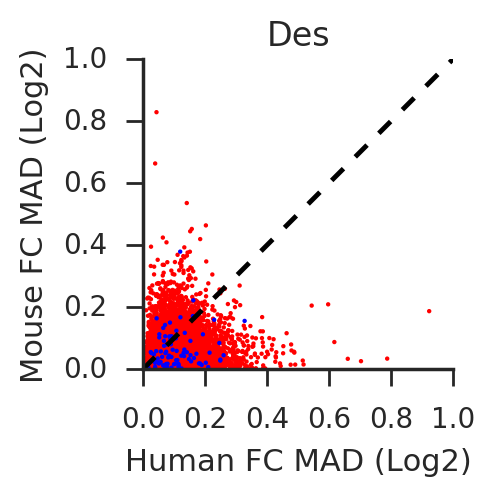

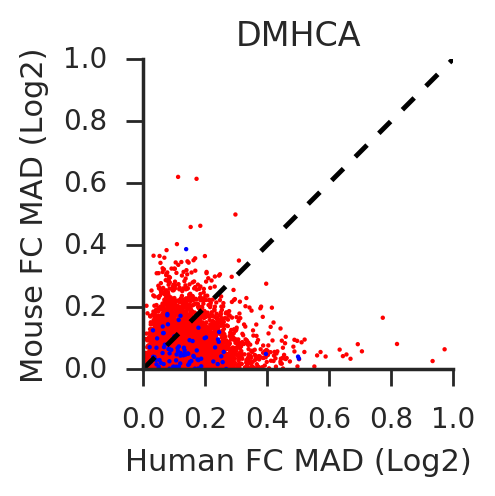

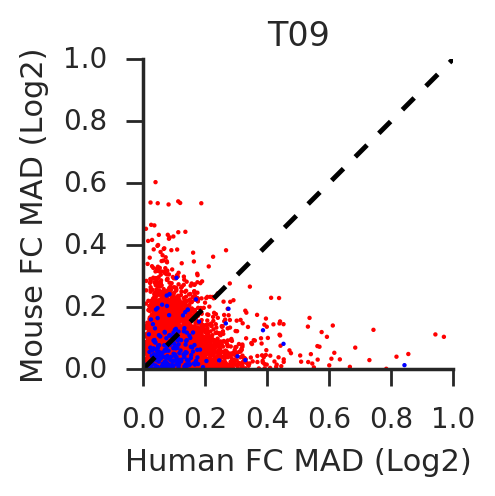

In [1817]:
genes = fc_mad_frame.index.values
for treatment in ['Des', 'DMHCA', 'T09']:
    human_mads = fc_mad_frame[treatment + ' human FC MAD'].values
    mouse_mads = fc_mad_frame[treatment + ' mouse FC MAD'].values
    
    if not treatment == 'Vehicle':
        up_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']
        down_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']
        diff_genes = set(up_genes).union(down_genes)
    else:
        diff_genes = set()
    colors = ['blue' if x in diff_genes else 'red' for x in genes]
    
    tuples = zip(genes, human_mads, mouse_mads, colors)
    sorted_tuples = sorted(tuples, key=lambda x:x[3], reverse=True)
    sorted_genes = [x[0] for x in sorted_tuples]
    sorted_human_mads = np.array([x[1] for x in sorted_tuples])
    sorted_mouse_mads = np.array([x[2] for x in sorted_tuples])
    sorted_colors = [x[3] for x in sorted_tuples]
    
    with sns.axes_style('ticks'):
        plt.figure(figsize=(2,2))
        plt.scatter(np.log2(sorted_human_mads+1),
                    np.log2(sorted_mouse_mads + 1),
                    marker='.', edgecolor='None', s=10,c=sorted_colors)
        plt.plot([0,12], [0,12], linestyle='--', c='black')
        ax = plt.gca()
        ax.set_xlim((0,1))
        ax.set_ylim((0,1))
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

        plt.title(treatment)
        plt.ylabel('Mouse FC MAD (Log2)')
        plt.xlabel('Human FC MAD (Log2)')
        
        sns.despine()
        plt.show()

## Plot distributions

In [ ]:
genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
# for treatment in sorted(treatment_sample_human_frame.columns.values):
for treatment in ['Des', 'DMHCA', 'T09']:
    if treatment == 'Vehicle':
        break
    for sample in treatment_sample_human_frame.index.values:
        if treatment_sample_human_frame.ix[sample,'Vehicle']:
            if treatment_sample_human_frame.ix[sample,treatment]:
                # uncorrected plots
                with sns.axes_style('whitegrid'):
                    plt.figure(figsize=(8,3))
                    # plot fold change distribution
                    plt.subplot(1,2,1)
                    treated_vals = rpkm_human_frame[treatment + '_' + sample]
                    vehicle_vals = rpkm_human_frame['Vehicle_'+sample]
                    
                    fold_change = (treated_vals +1) / (vehicle_vals +1)
                    fold_change = np.log2(fold_change)
                    sns.distplot(fold_change)
                    plt.xlabel('Log2 Fold Change')
                    plt.ylabel('Frequency')
                    plt.xlim(-3,3)

                    # plot rpkm distribution
                    plt.subplot(1,2,2)
                    sns.distplot(np.log2(treated_vals +1), hist_kws={'alpha':0.5}, label=treatment)
                    plt.xlim(0,10)
                    sns.distplot(np.log2(vehicle_vals +1), hist_kws={'alpha':0.5}, label='Vehicle')
                    plt.legend()
                    plt.xlim(0,20)
                    plt.xlabel('Log2 Reads')
                    plt.suptitle(treatment + '_' + sample)
                    plt.show()
                    plt.close()
                
                # corrected plots
                
#                 correct according to mean
                veh_mean = np.median(vehicle_vals)
                treated_mean = np.median(treated_vals)
                if veh_mean > treated_mean:
                    corrected_vehicle_vals = vehicle_vals
                    corrected_treated_vals = treated_vals + (veh_mean - treated_mean)
                else:
                    corrected_vehicle_vals = vehicle_vals+ (treated_mean - veh_mean)
                    corrected_treated_vals = treated_vals
#                 corrected_vehicle_vals, corrected_treated_vals = quantileNormalize(vehicle_vals, treated_vals)
                with sns.axes_style('darkgrid'):
                    plt.figure(figsize=(8,3))
                    plt.subplot(1,2,1)
                    fold_change = (corrected_treated_vals +1) / (corrected_vehicle_vals +1)
                    fold_change = np.log2(fold_change)
                    sns.distplot(fold_change)
                    plt.xlabel('Log2 Fold Change')
                    plt.ylabel('Frequency')
                    plt.xlim(-3,3)

                    # plot rpkm distribution
                    plt.subplot(1,2,2)
                    sns.distplot(np.log2(corrected_treated_vals +1), hist_kws={'alpha':0.5}, label=treatment)
                    plt.xlim(0,10)
                    sns.distplot(np.log2(corrected_vehicle_vals +1), hist_kws={'alpha':0.5}, label='Vehicle')
                    plt.legend()
                    plt.xlim(0,20)
                    plt.xlabel('Log2 Reads')
                    plt.suptitle(treatment + '_' + sample + ' Normalized')
                    plt.show()
                

In [1818]:
import warnings
warnings.filterwarnings('ignore')

In [1819]:
fold_threshold = 2.0
ratio_threshold = 2.0
stats_human_frame = rpkm_human_frame[[]]
stats_human_frame['gene'] = rpkm_human_frame.index.values
distance_threshold = fold_threshold - 1
foldChange_human_frame = rpkm_human_frame[[]]
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    print(treatment)   
    foldChange_data = rpkm_human_frame[[]]
    for sample in selected_human_samples:
        if treatment_sample_human_frame.ix[sample,'Vehicle']:
            if treatment_sample_human_frame.ix[sample,treatment]:
                sample_genes_dict[sample] = set()
                treated_vals = rpkm_human_frame[treatment + '_' + sample]
                vehicle_vals = rpkm_human_frame['Vehicle_'+sample]
                
                # normalize values
#                 corrected_vehicle_vals, corrected_treated_vals = quantileNormalize(vehicle_vals, treated_vals)
                corrected_vehicle_vals = vehicle_vals
                corrected_treated_vals = treated_vals
                
                #calculate fold change
                fold_change = np.log2((corrected_treated_vals +1) / (corrected_vehicle_vals +1)                 )
                foldChange_data[treatment + '_' + sample] = fold_change
                foldChange_human_frame[treatment + '_' + sample] = fold_change
    mads = []
    medians = []
    vals = foldChange_data.values
    current_diff_genes = []
    for i in range(len(current_genes)):
        current_vals = vals[i]
        current_mad = calcMAD(current_vals)
        mads.append(current_mad)
        median = np.median(current_vals)
        medians.append(median)

    stats_human_frame[treatment + ' Median Log2 FC'] = medians
    stats_human_frame[treatment + ' Log2 FC MAD'] = mads


Des
DMHCA
T09
GW
Mepip


In [1820]:
fold_threshold = 2.0
ratio_threshold = 2.0
stats_mouse_frame = rpkm_mouse_frame[[]]
stats_mouse_frame['gene'] = rpkm_mouse_frame.index.values
distance_threshold = fold_threshold - 1
foldChange_mouse_frame = rpkm_mouse_frame[[]]
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    print(treatment)   
    foldChange_data = rpkm_mouse_frame[[]]
    for sample in treatment_sample_mouse_frame.index.values:
        if treatment_sample_mouse_frame.ix[sample,'Vehicle']:
            if treatment_sample_mouse_frame.ix[sample,treatment]:
                sample_genes_dict[sample] = set()
                treated_vals = rpkm_mouse_frame[treatment + '_' + sample]
                vehicle_vals = rpkm_mouse_frame['Vehicle_'+sample]
                
                # normalize values
#                 corrected_vehicle_vals, corrected_treated_vals = quantileNormalize(vehicle_vals, treated_vals)
                corrected_vehicle_vals = vehicle_vals
                corrected_treated_vals = treated_vals
                
                #calculate fold change
                fold_change = np.log2((corrected_treated_vals +1) / (corrected_vehicle_vals +1)                 )
                foldChange_data[treatment + '_' + sample] = fold_change
                foldChange_mouse_frame[treatment + '_' + sample] = fold_change
    mads = []
    medians = []
    vals = foldChange_data.values
    current_diff_genes = []
    for i in range(len(current_genes)):
        current_vals = vals[i]
        current_mad = calcMAD(current_vals)
        mads.append(current_mad)
        median = np.median(current_vals)
        medians.append(median)

    stats_mouse_frame[treatment + ' Median Log2 FC'] = medians
    stats_mouse_frame[treatment + ' Log2 FC MAD'] = mads



Des
DMHCA
T09
GW
Mepip


In [1821]:
### wilcoxon rank test
treatment_gene_wilcoxon_dict = {x:set() for x in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']}
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    pvals = []
    for gene in rpkm_human_frame.index.values:
        veh_vals = rpkm_human_frame.ix[gene, ['Vehicle_' + x for x in selected_human_samples]].values
        treatment_vals = rpkm_human_frame.ix[gene, [treatment + '_' + x for x in selected_human_samples]].values
        stat, p = scipy.stats.wilcoxon(veh_vals, treatment_vals)
        pvals.append(p)
    stats_human_frame[treatment + ' Wilcoxon p-value'] = pvals
stats_human_frame = stats_human_frame[sorted(stats_human_frame.columns.values)]

In [1822]:
### wilcoxon rank test
treatment_gene_wilcoxon_dict = {x:set() for x in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']}
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    pvals = []
    for gene in rpkm_mouse_frame.index.values:
        veh_vals = rpkm_mouse_frame.ix[gene, ['Vehicle_' + x for x in treatment_sample_mouse_frame.index.values]].values
        treatment_vals = rpkm_mouse_frame.ix[gene, [treatment + '_' + x for x in treatment_sample_mouse_frame.index.values]].values
        stat, p = scipy.stats.wilcoxon(veh_vals, treatment_vals)
        pvals.append(p)
    stats_mouse_frame[treatment + ' Wilcoxon p-value'] = pvals
stats_mouse_frame = stats_mouse_frame[sorted(stats_mouse_frame.columns.values)]

In [1823]:
### find significant genes
ratio_threshold = 2.0
fold_threshold = abs(np.log2(2.0))
p_threshold = 0.05
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    
    significant_frame = stats_human_frame[(stats_human_frame[treatment + ' Median Log2 FC'].abs() > fold_threshold) &
                                    (stats_human_frame[treatment + ' Wilcoxon p-value'] < p_threshold)]
    significant_frame[treatment + ' Effect/Variance Ratio'] = \
        significant_frame[treatment + ' Median Log2 FC'].abs()/significant_frame[treatment + ' Log2 FC MAD']
    significant_frame = significant_frame[significant_frame[treatment + ' Effect/Variance Ratio'] > ratio_threshold]
    significant_frame = significant_frame.sort(treatment + ' Effect/Variance Ratio')

    up_genes = significant_frame[significant_frame[treatment + ' Median Log2 FC'] > 0].index.values
    down_genes = significant_frame[significant_frame[treatment + ' Median Log2 FC'] < 0].index.values
    condition_significantGenes_dict['humanMatched_'+treatment.lower()+'_up'] = set(up_genes)
    condition_significantGenes_dict['humanMatched_'+treatment.lower()+'_down'] = set(down_genes)

### Show Overlap with Mouse Genes

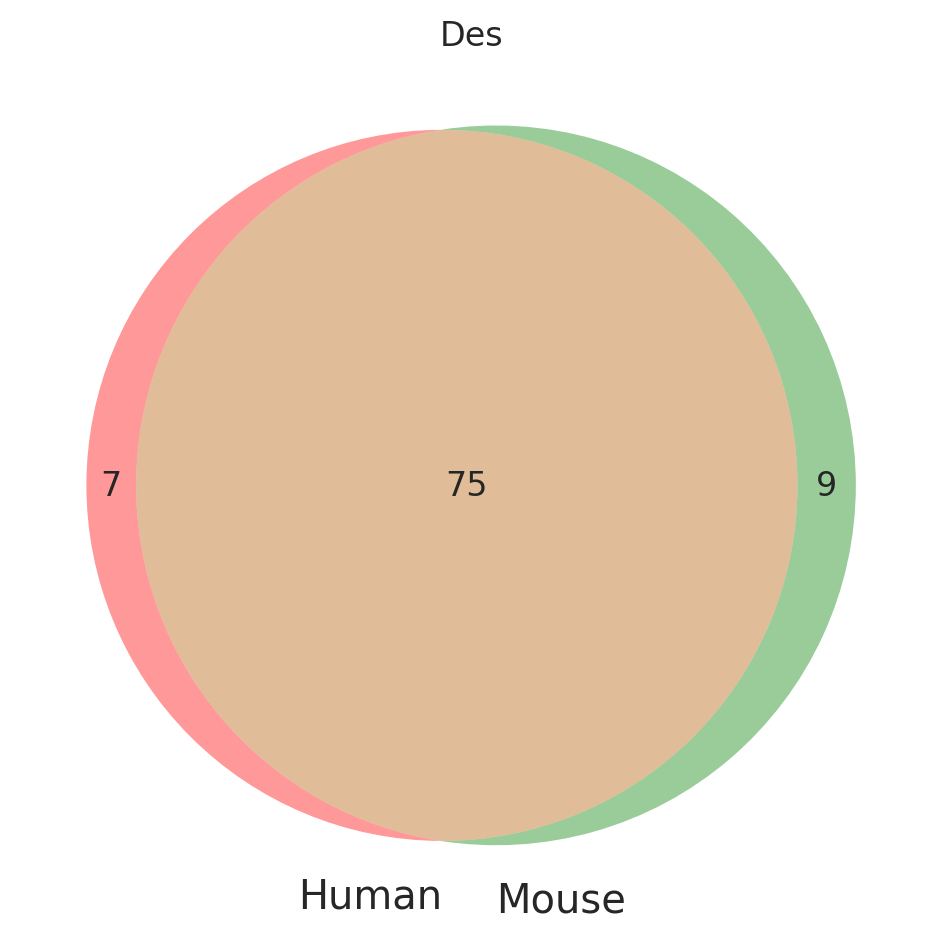

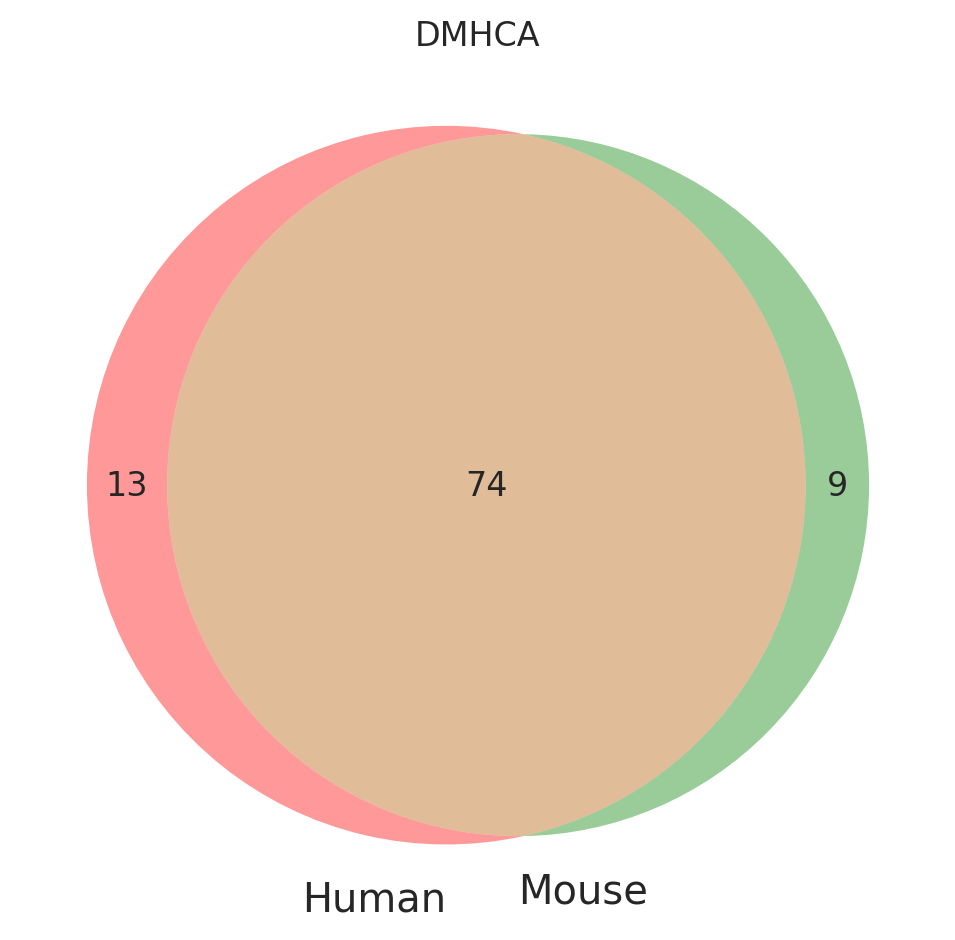

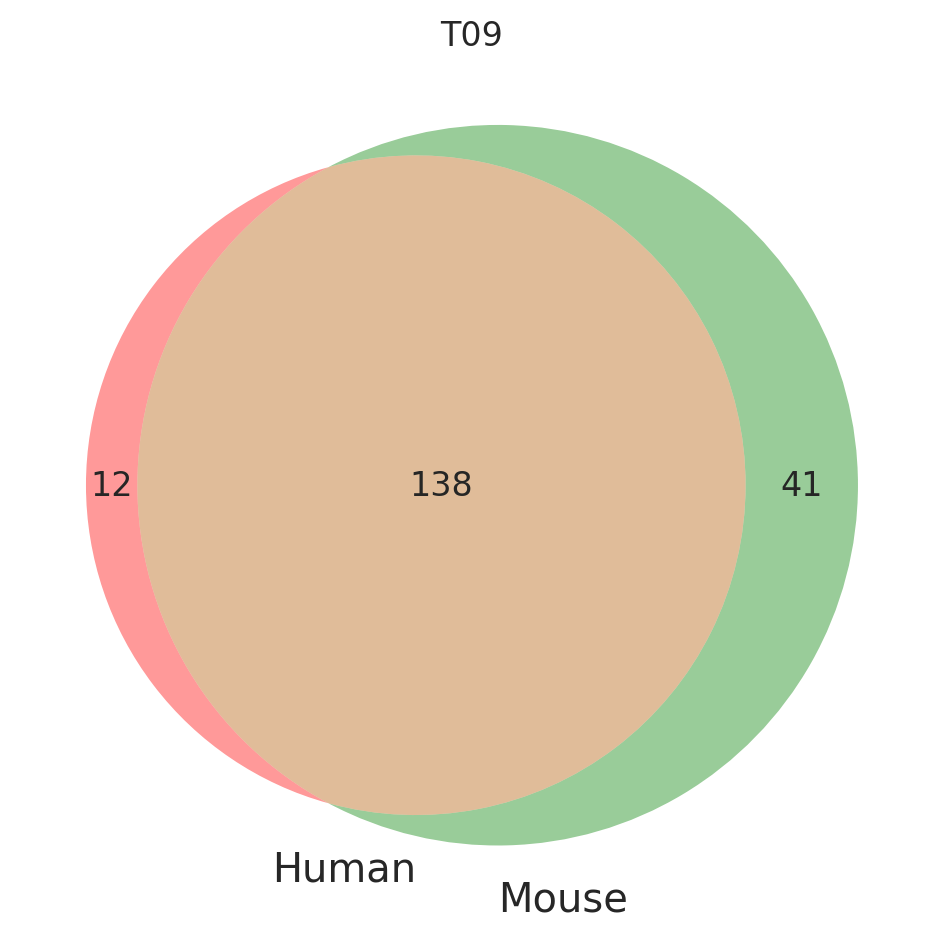

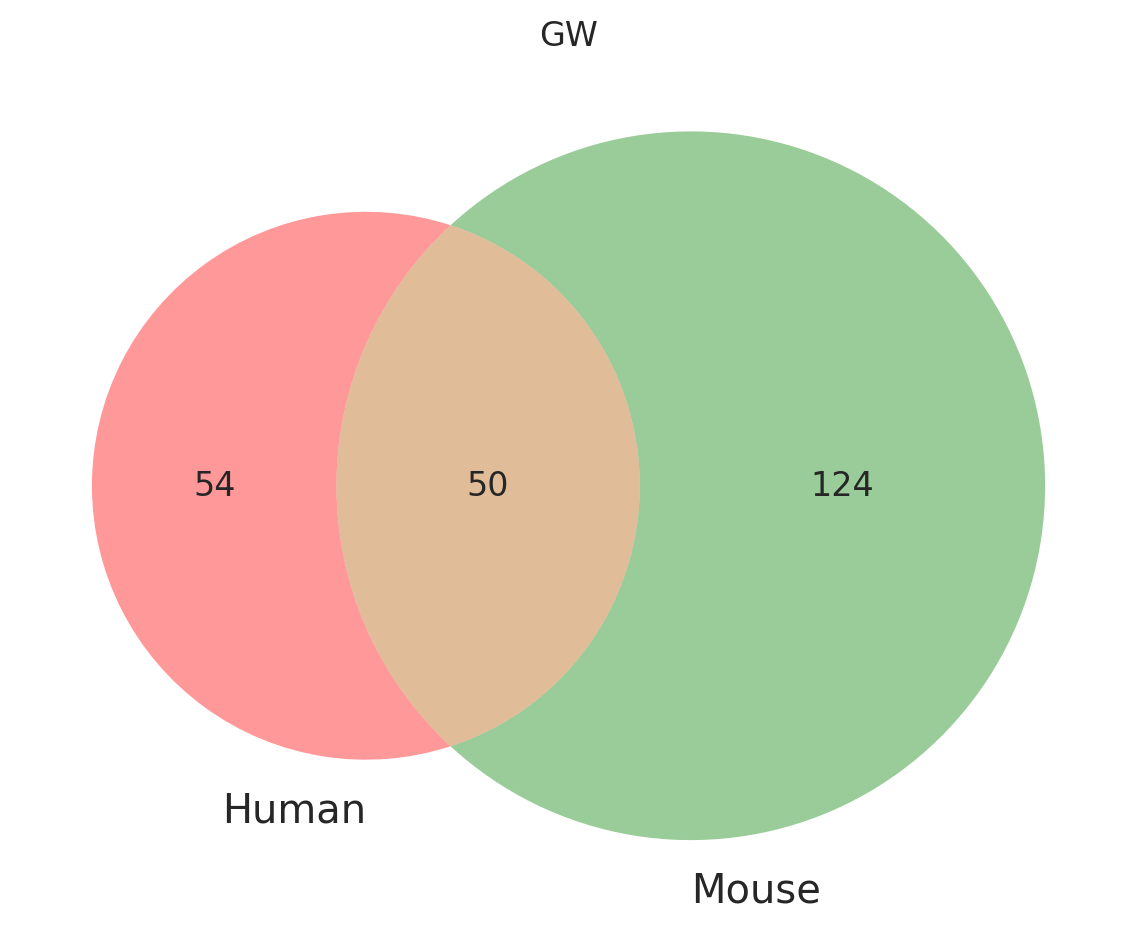

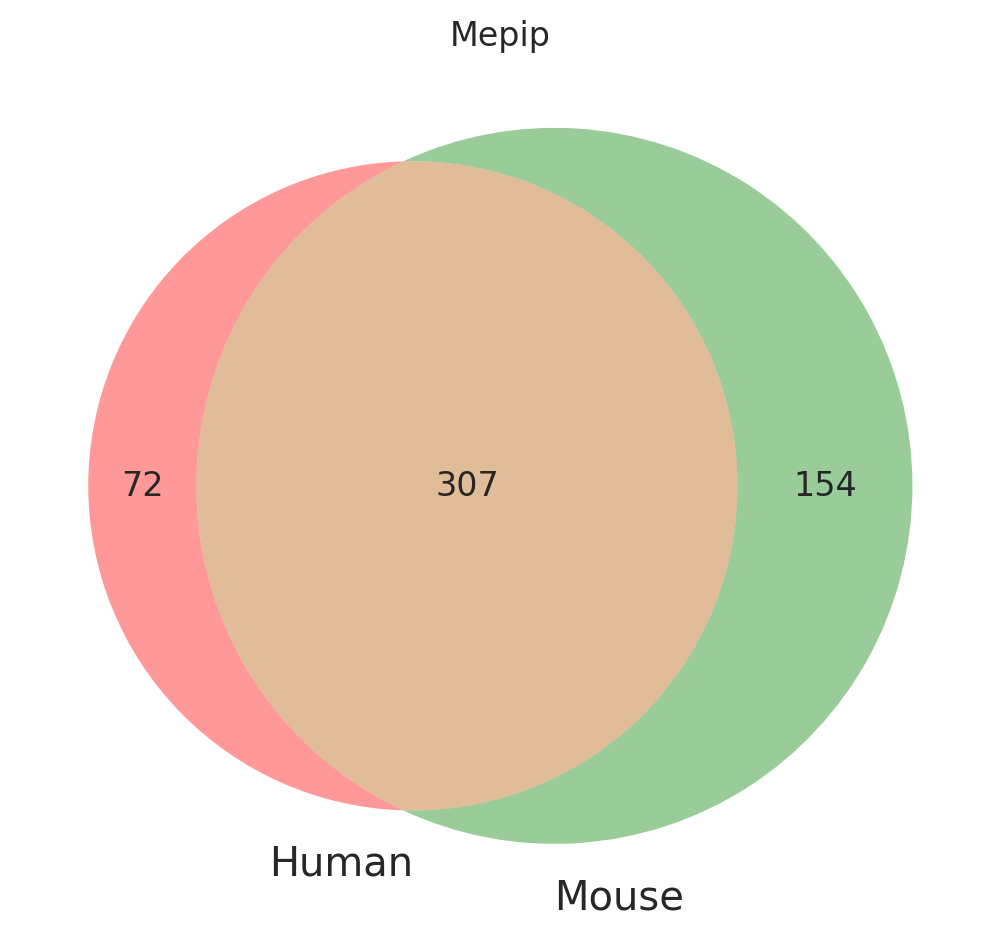

In [1827]:
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    mouse_genes_up = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    mouse_genes_down = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    
    mouse_genes = mouse_genes_up.union(mouse_genes_down)
    
    human_genes_up_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_matched = human_genes_up_matched.union(human_genes_down_matched)

    human_genes_up_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_pooled = human_genes_up_pooled.union(human_genes_down_pooled)
    
#     matplotlib_venn.venn3([human_genes_matched, human_genes_pooled, mouse_genes],['human_matched', 'human_pooled', 'mouse'])
    matplotlib_venn.venn2([human_genes_matched, mouse_genes],['Human', 'Mouse'])
    plt.title(treatment)
    plt.savefig(treatment + '_human_vs_mouse_vennDiagram.pdf', bbox_inches='tight')
    plt.show()
    

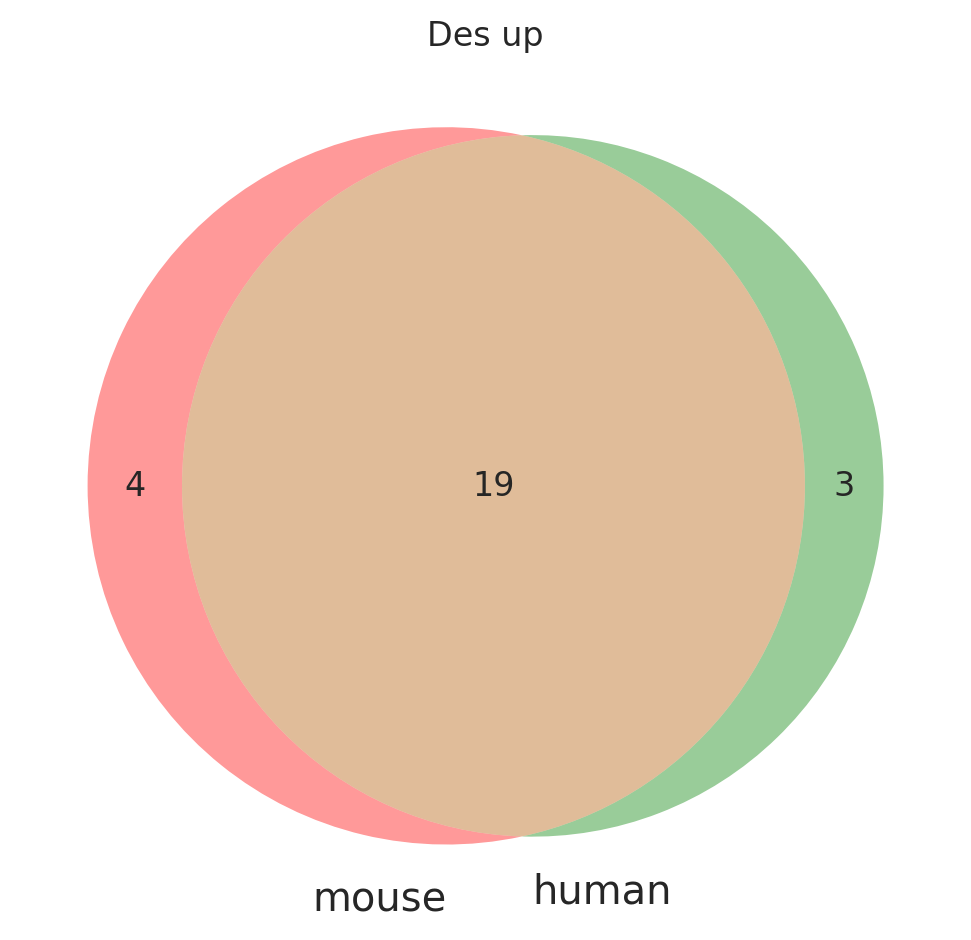

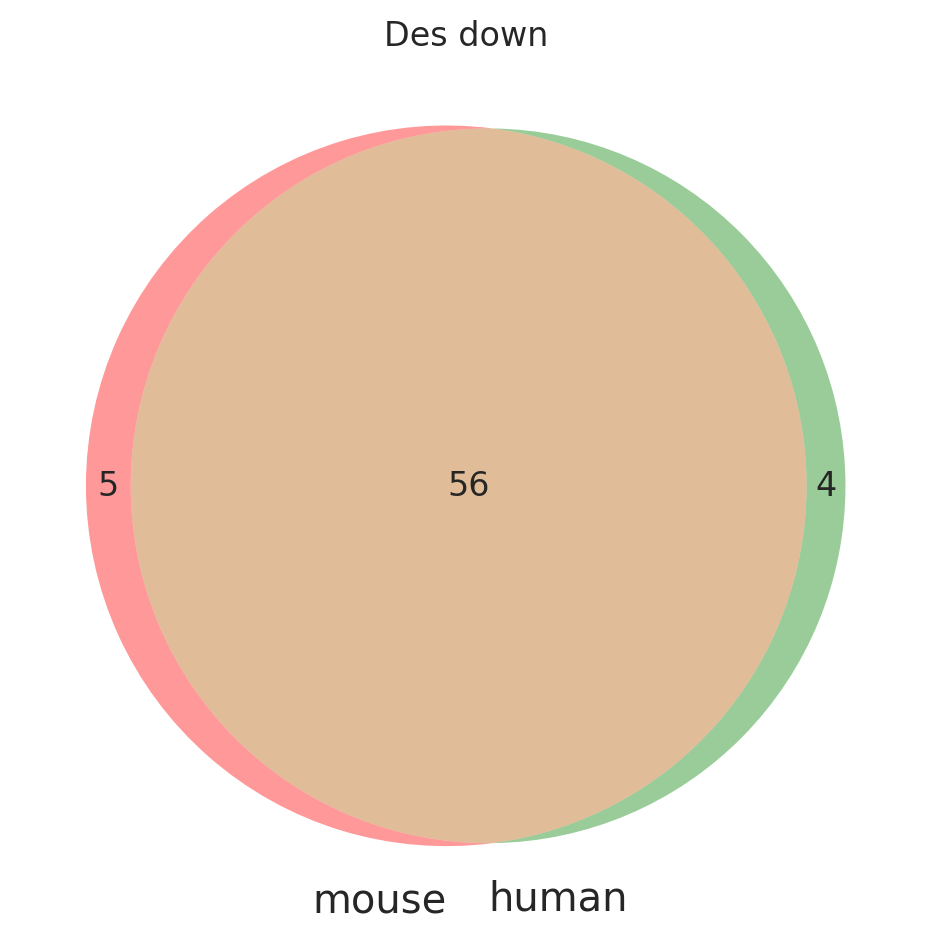

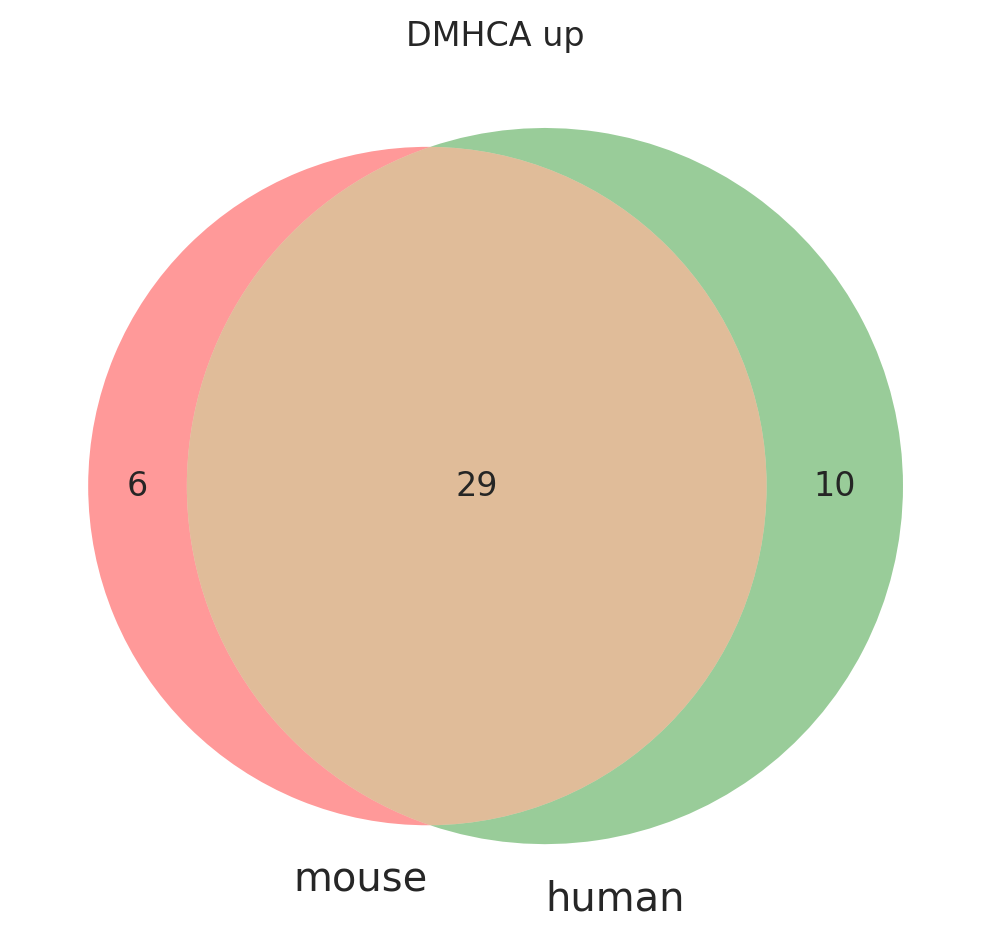

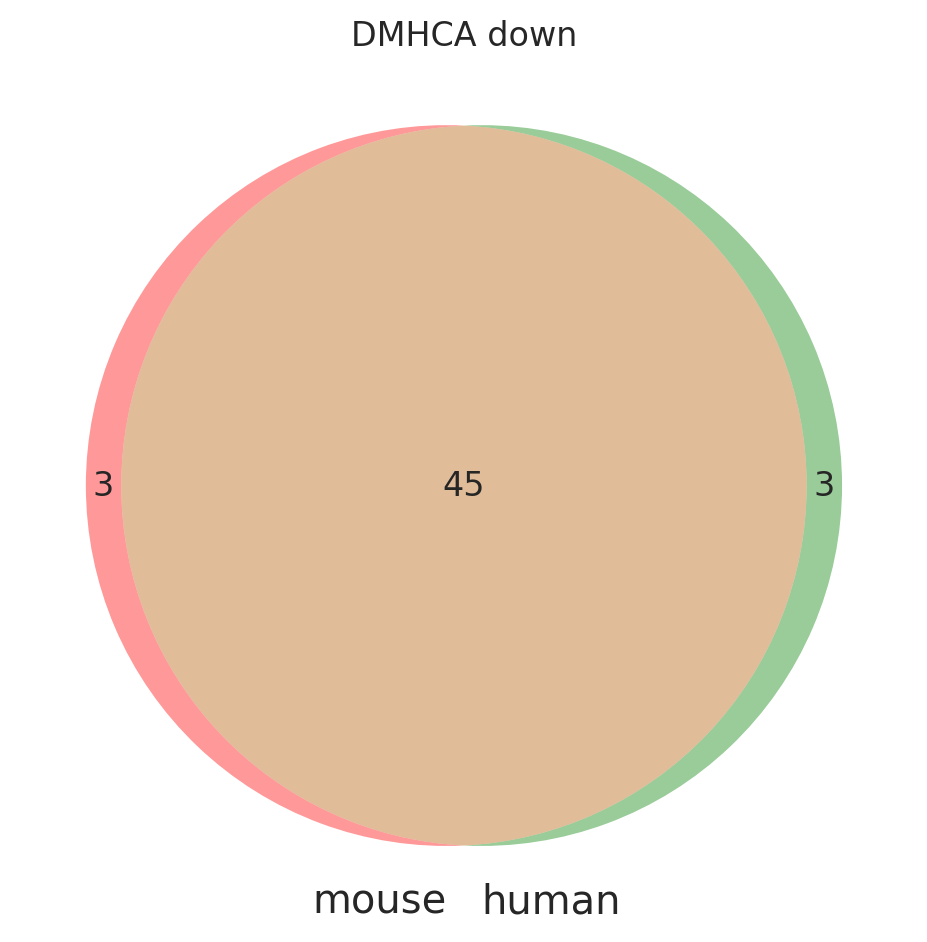

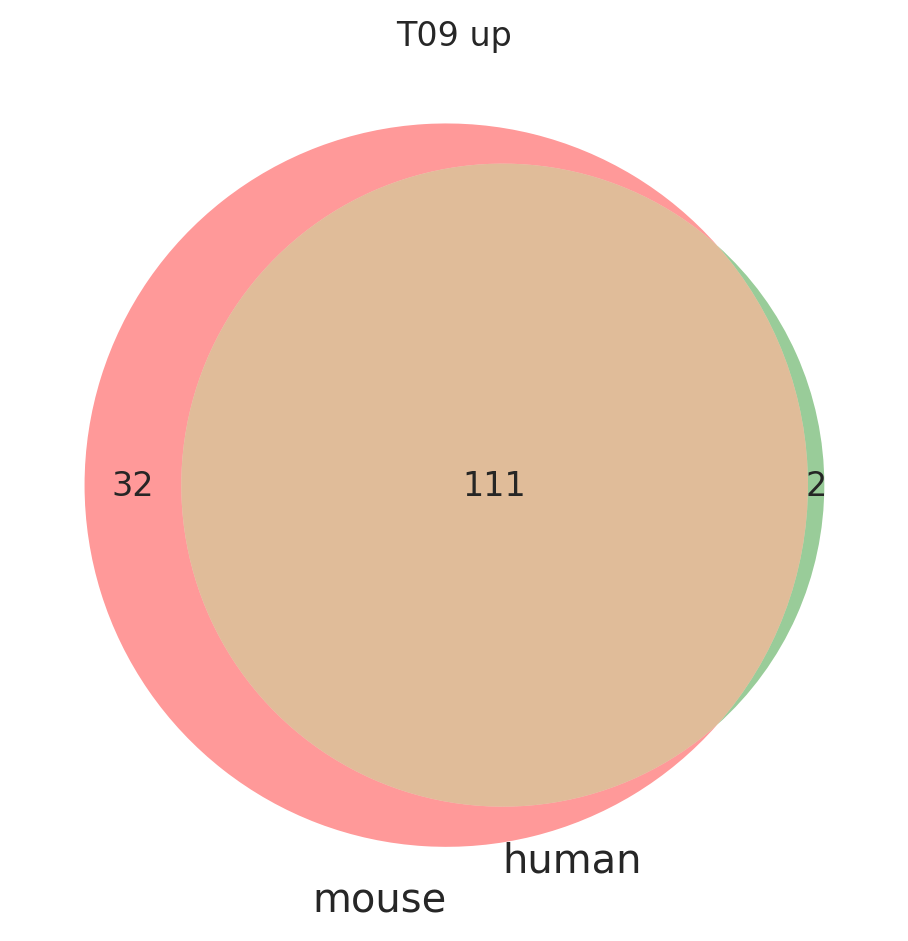

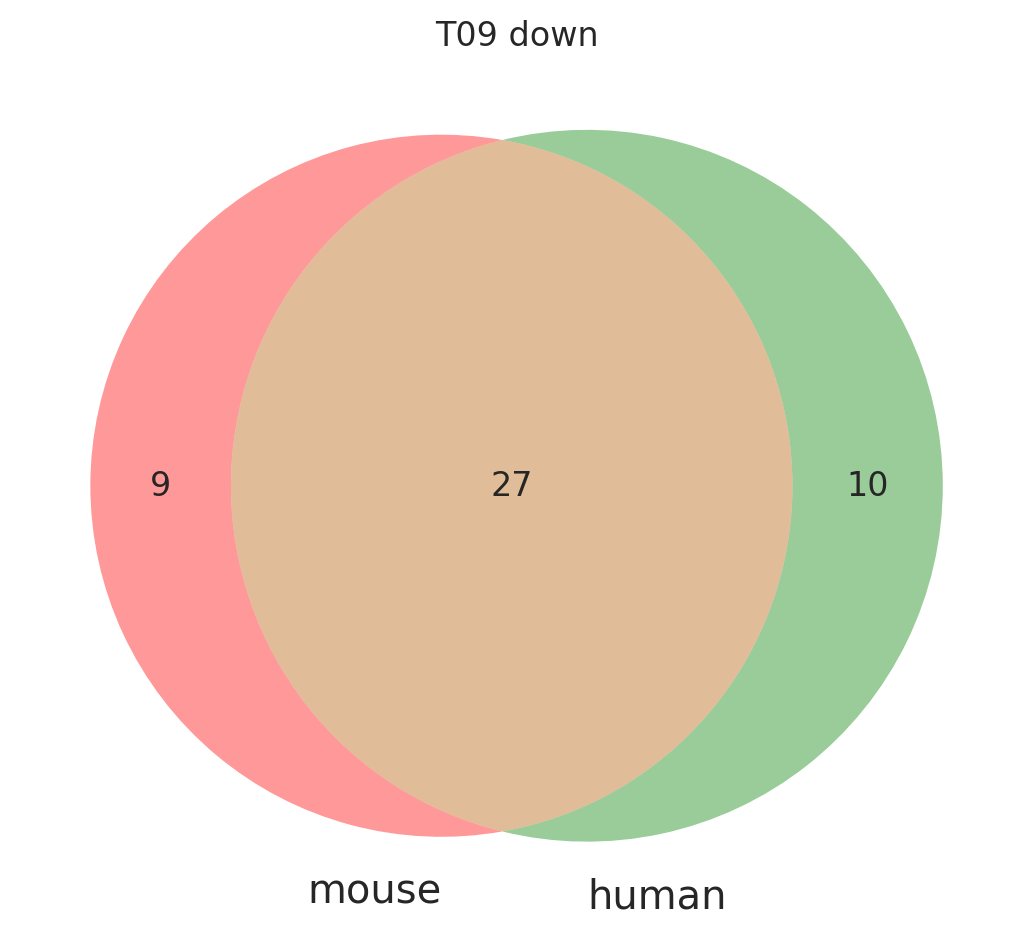

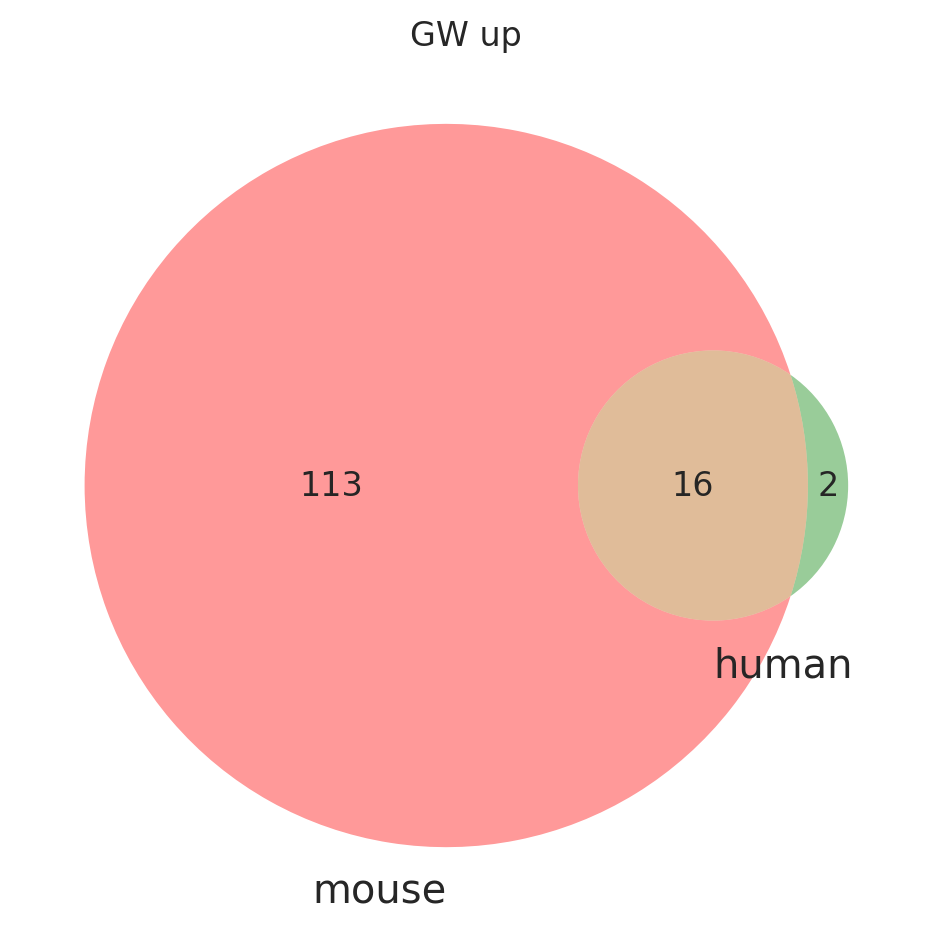

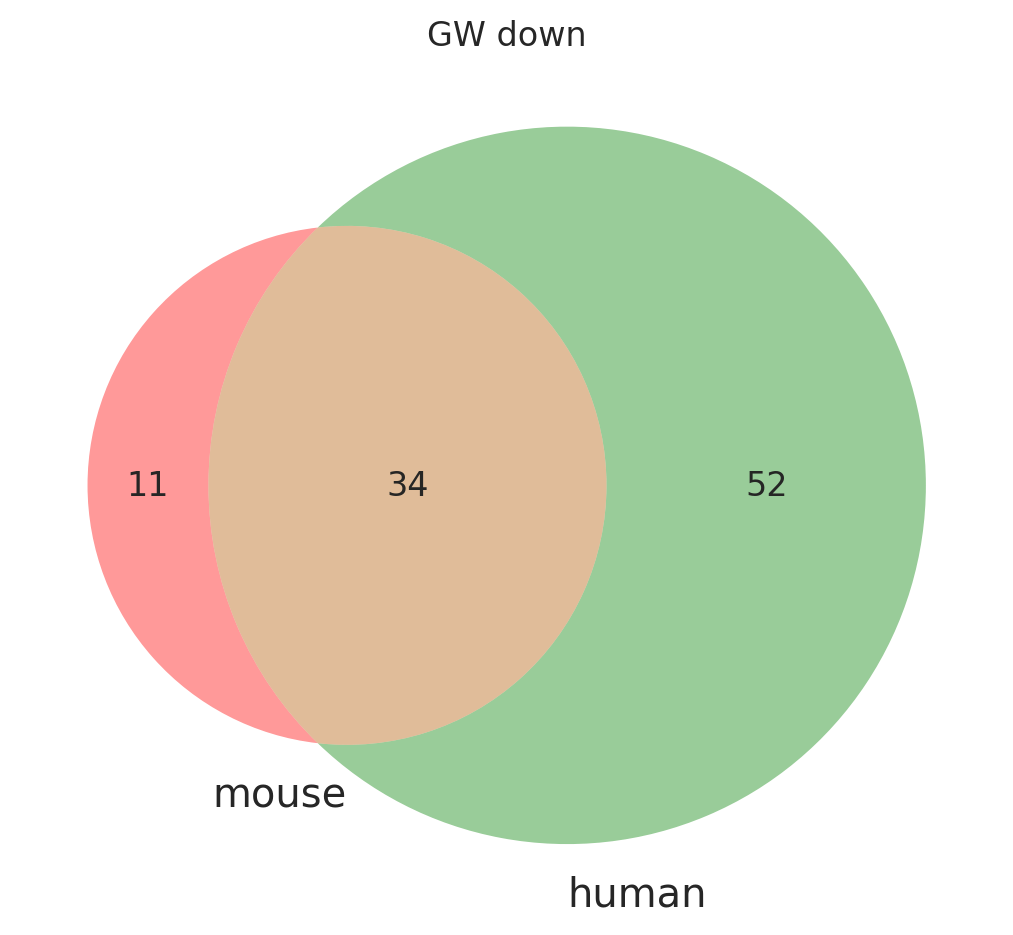

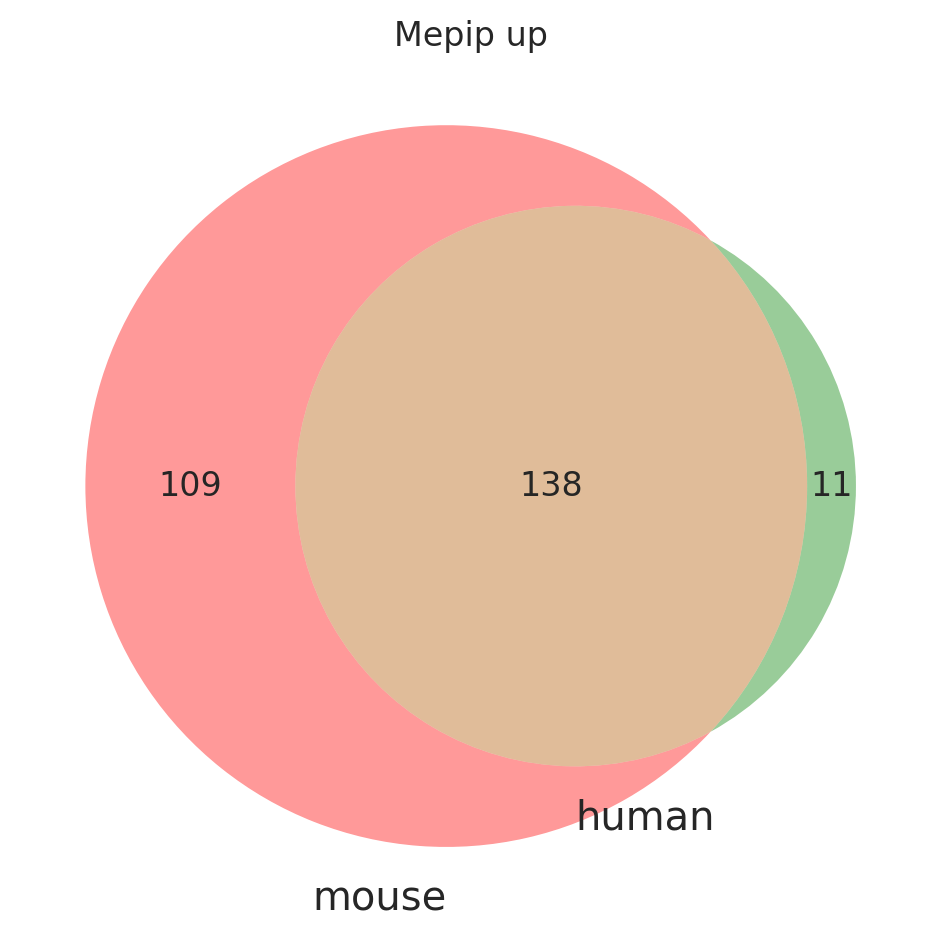

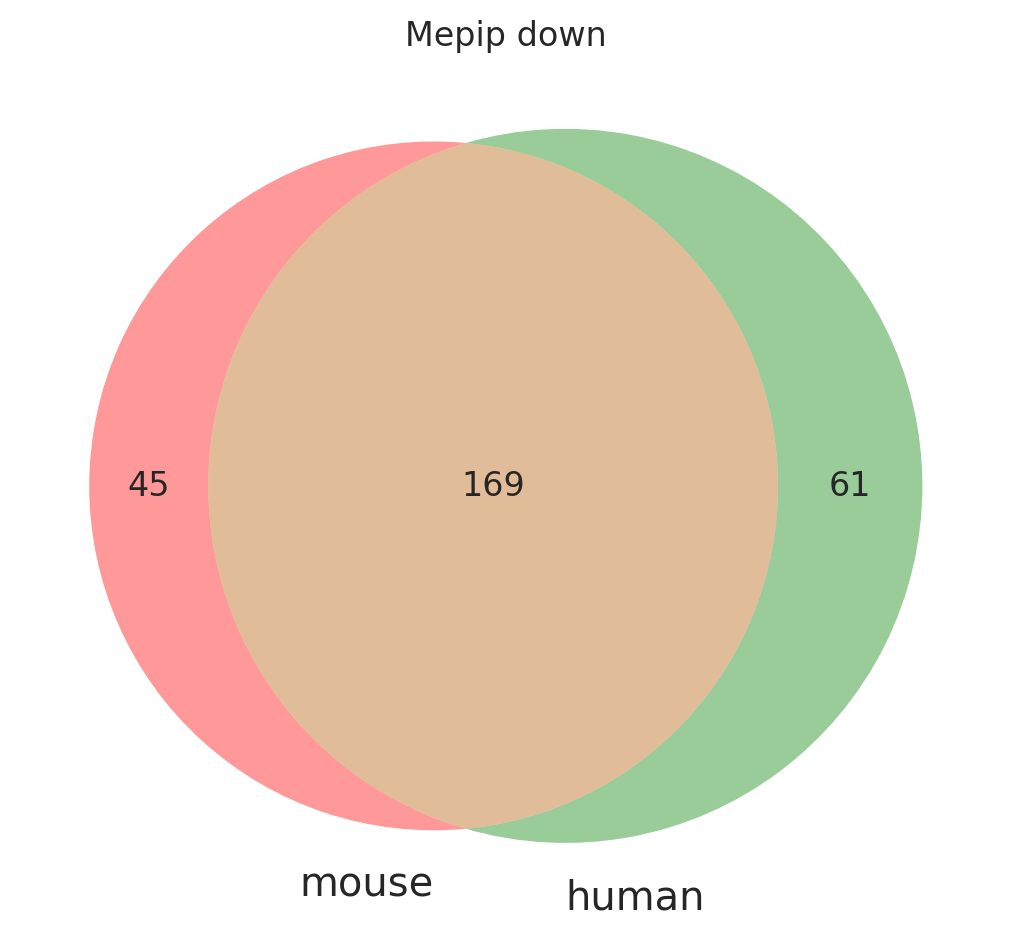

In [1865]:
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    for direction in ['up', 'down']:
        gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes),
            set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes)]


#         mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
#         intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
#         human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

#         mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
#         human_frame = stats_human_frame[['gene']+[treatment + ' '+ x for x in ['Log2 FC MAD', 'Median Log2 FC', 'Wilcoxon p-value']]]
#         mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
#         intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
#                                         human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
#         intersection_frame = intersection_frame.sort(treatment + ' Median Log2 FC')
#         human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]
#         human_specific_frame = human_specific_frame.sort(treatment + ' Median Log2 FC')
#         # write output file
#         mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
#         with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
#             intersection_frame.to_csv(f, index=False, sep='\t')
#         with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
#             human_specific_frame.to_csv(f, index=False, sep='\t')

        # plot venn diagram
        matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
        plt.title(treatment + ' ' + direction)

        plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')
        plt.show()


## Heatmap

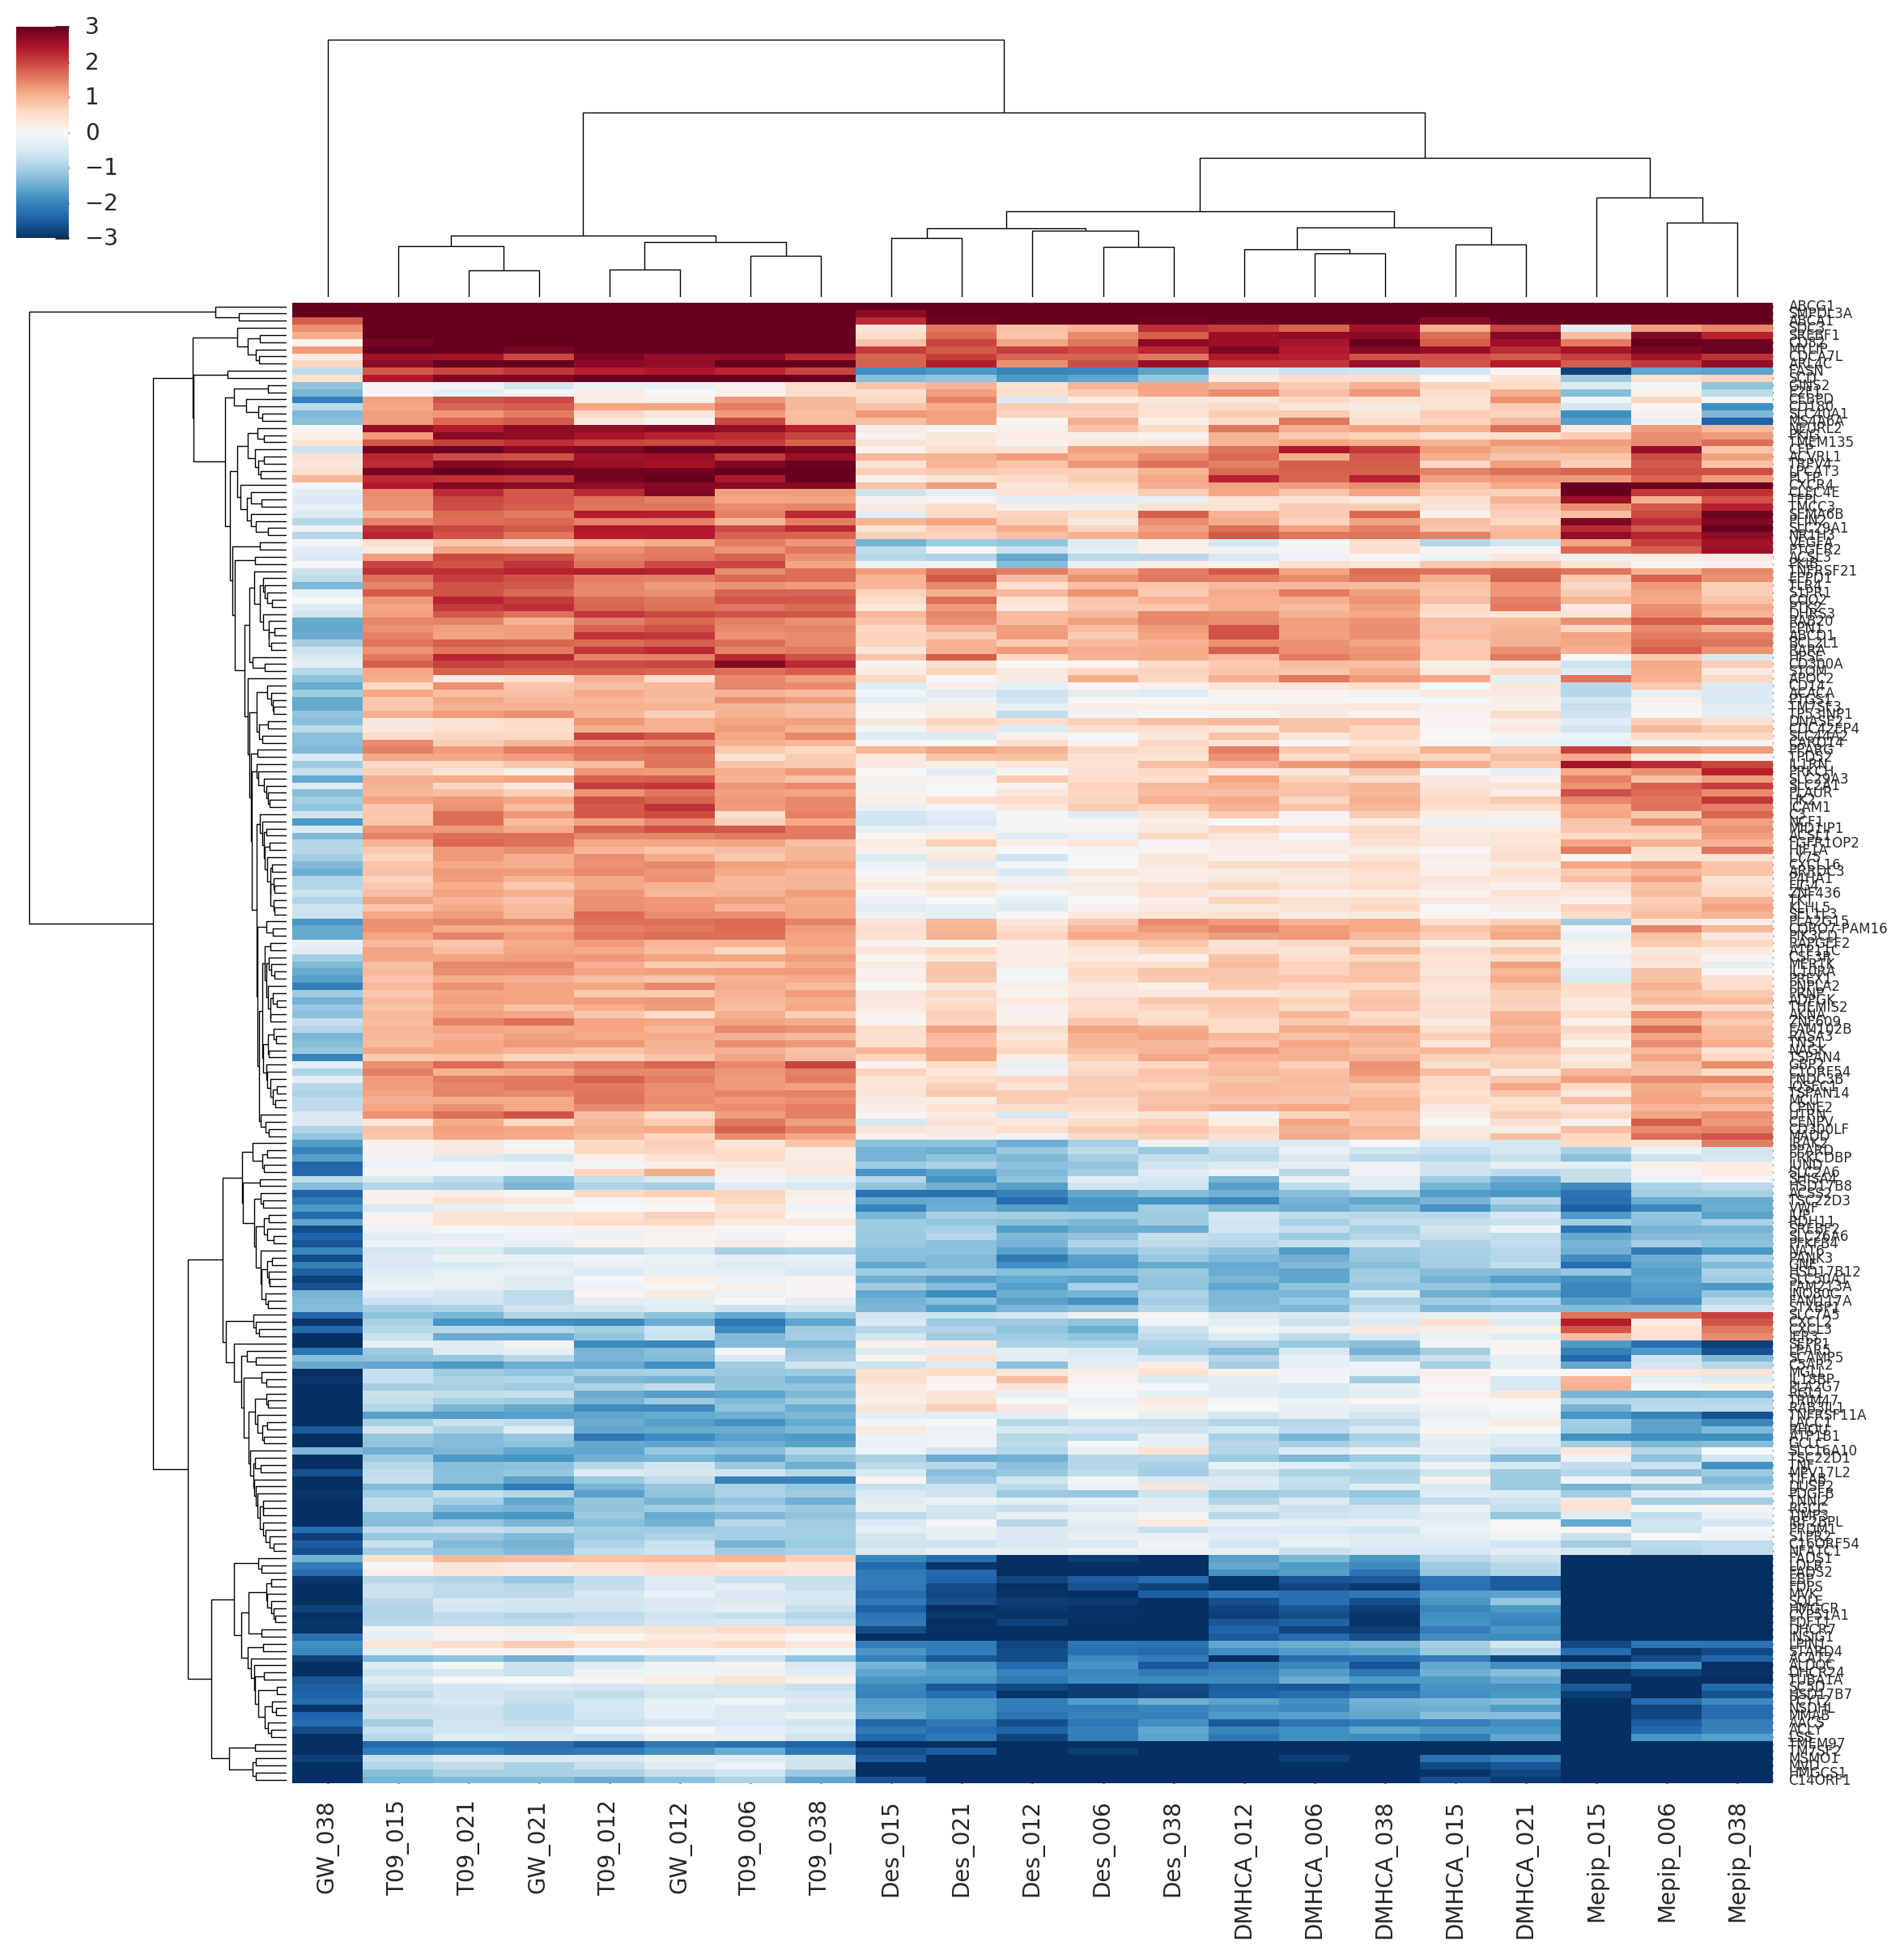

In [1890]:
fold_threshold = 1
diff_genes = set()
for treatment in ['Des', 'DMHCA', 'T09']:
    
    human_genes_up_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_matched = human_genes_up_matched.union(human_genes_down_matched)
    diff_genes = diff_genes.union(human_genes_matched)

data= foldChange_human_frame[foldChange_human_frame.index.isin(diff_genes)]
data = data[data.abs().max(axis=1) > fold_threshold]

with sns.axes_style('ticks',{'ytick.direction':'in', 'xtick.direction':'in'}):
    cg = sns.clustermap(data,
                        figsize=(14,14),
                        vmin=-3,
                        vmax=3)

    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, size=6);
    plt.savefig('matched_human_heatmap.pdf',bbox_inches='tight')

In [1839]:
columns = list(rpkm_human_frame.columns.values[:9])
for treatment in ['Des', 'DMHCA', 'T09', 'Vehicle']:
    for sample in selected_human_samples:
        columns.append(treatment + '_' + sample)

In [1840]:
### save rpkm values from heatmap
fold_threshold = 2
diff_genes = set()
for treatment in ['Des', 'DMHCA', 'T09']:
    
    human_genes_up_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_matched = human_genes_up_matched.union(human_genes_down_matched)
    diff_genes = diff_genes.union(human_genes_matched)

data= foldChange_human_frame[foldChange_human_frame.index.isin(diff_genes)]
data = data[data.abs().max(axis=1) > fold_threshold]


rpkm_human_frame[rpkm_human_frame.index.isin(data.index.values)][columns].to_csv('human_matched_rpkm.tsv', index=False, sep='\t')

## heat map for orthologous genes that show differential responses in mouse and human

In [1880]:
chris_genes =['MGLL',
'PLA2G7',
'CKB',
'LAT',
'CXCL2',
'IER3',
'FZD1',
'CYP27A1',
'FAM213B',
'GYPC',
'ATF3',
'JDP2',
'CTSK',
'EMP1',
'DUSP2',
'TSC22D1',
'PDGFB',
'TMEM55B',
'FGL2',
'RGL1',
'CAMK1',
'TGFBI',
'ACOT7',
'TMEM256',
'CRIP1',
'ISOC2',
'OAZ2',
'EVL',
'GALM',
'LACC1',
'SEPP1',
'HES6',
'LPAR5',
'NUDT8',
'IGFBP4',
'IL7R',
'SLC38A2',
'SLC29A1',
'NR1H3',
'PLIN2',
'SEMA6B',
'PTGER2',
'TFPI',
'RAB20',
'IL1RN',
'TMCC3',
'PLAUR',
'HK2',
'SLC2A1',
'CD300A',
'EXT1',
'HPSE',
'GBP2',
'STOM',
'TNFRSF21',
'TRPV4',
'S1PR1',
'COQ2',
'RARA',
'DHRS3',
'PTK2',
'CLEC4E',
'CXCR4',
'IL1A',
'C19ORF38',
'IL18BP']

In [1881]:
for g in chris_genes:
    if not (g in foldChange_human_frame.index.values or g in foldChange_mouse_frame.index.values):
        print(g)

In [1879]:
len(chris_genes)

65

In [1884]:
for g in sorted(foldChange_human_frame.index.values):
    print(g)

AAAS
AACS
AAED1
AAGAB
AAMDC
AAMP
AAR2
AARS
AARSD1
AASDHPPT
AATF
AATK
ABCA1
ABCB10
ABCB7
ABCB8
ABCC1
ABCC3
ABCC5
ABCD1
ABCD3
ABCD4
ABCE1
ABCF1
ABCF2
ABCF3
ABCG1
ABHD10
ABHD11
ABHD12
ABHD13
ABHD14B
ABHD16A
ABHD17A
ABHD17B
ABHD2
ABHD4
ABHD5
ABHD8
ABI1
ABI3
ABL1
ABL2
ABR
ABRACL
ABTB1
ACAA1
ACAA2
ACACA
ACAD8
ACAD9
ACADM
ACADS
ACADVL
ACAP2
ACAT1
ACAT2
ACBD3
ACBD5
ACBD6
ACD
ACE
ACER3
ACIN1
ACLY
ACO1
ACO2
ACOT11
ACOT13
ACOT2
ACOT7
ACOT8
ACOT9
ACOX1
ACOX3
ACP1
ACP2
ACSF3
ACSL1
ACSL3
ACSL4
ACSL5
ACSS1
ACSS2
ACTA2
ACTB
ACTG1
ACTL6A
ACTN1
ACTN4
ACTR10
ACTR1A
ACTR1B
ACTR2
ACTR3
ACTR6
ACTR8
ACVR1
ACVR1B
ACVRL1
ACYP1
ADAM10
ADAM15
ADAM17
ADAM8
ADAM9
ADAP1
ADAP2
ADAR
ADCK1
ADCK2
ADCY3
ADCY7
ADD1
ADD3
ADH5
ADI1
ADIPOR1
ADIPOR2
ADK
ADNP
ADO
ADPGK
ADPRH
ADPRHL2
ADRM1
ADSL
ADSS
AEN
AES
AFF1
AFF4
AFG3L2
AFTPH
AGA
AGAP3
AGBL5
AGFG1
AGGF1
AGO1
AGO2
AGO4
AGPAT1
AGPAT2
AGPAT3
AGPAT5
AGPS
AGTPBP1
AGTRAP
AHCYL1
AHCYL2
AHNAK
AHSA1
AIDA
AIF1
AIFM1
AIFM2
AIG1
AIM1
AIMP1
AIMP2
AIP
AK2
AK3
AK6
AKAP1
AKAP10
AKAP11
AKA

(66, 5) (66, 5)
(66, 10)


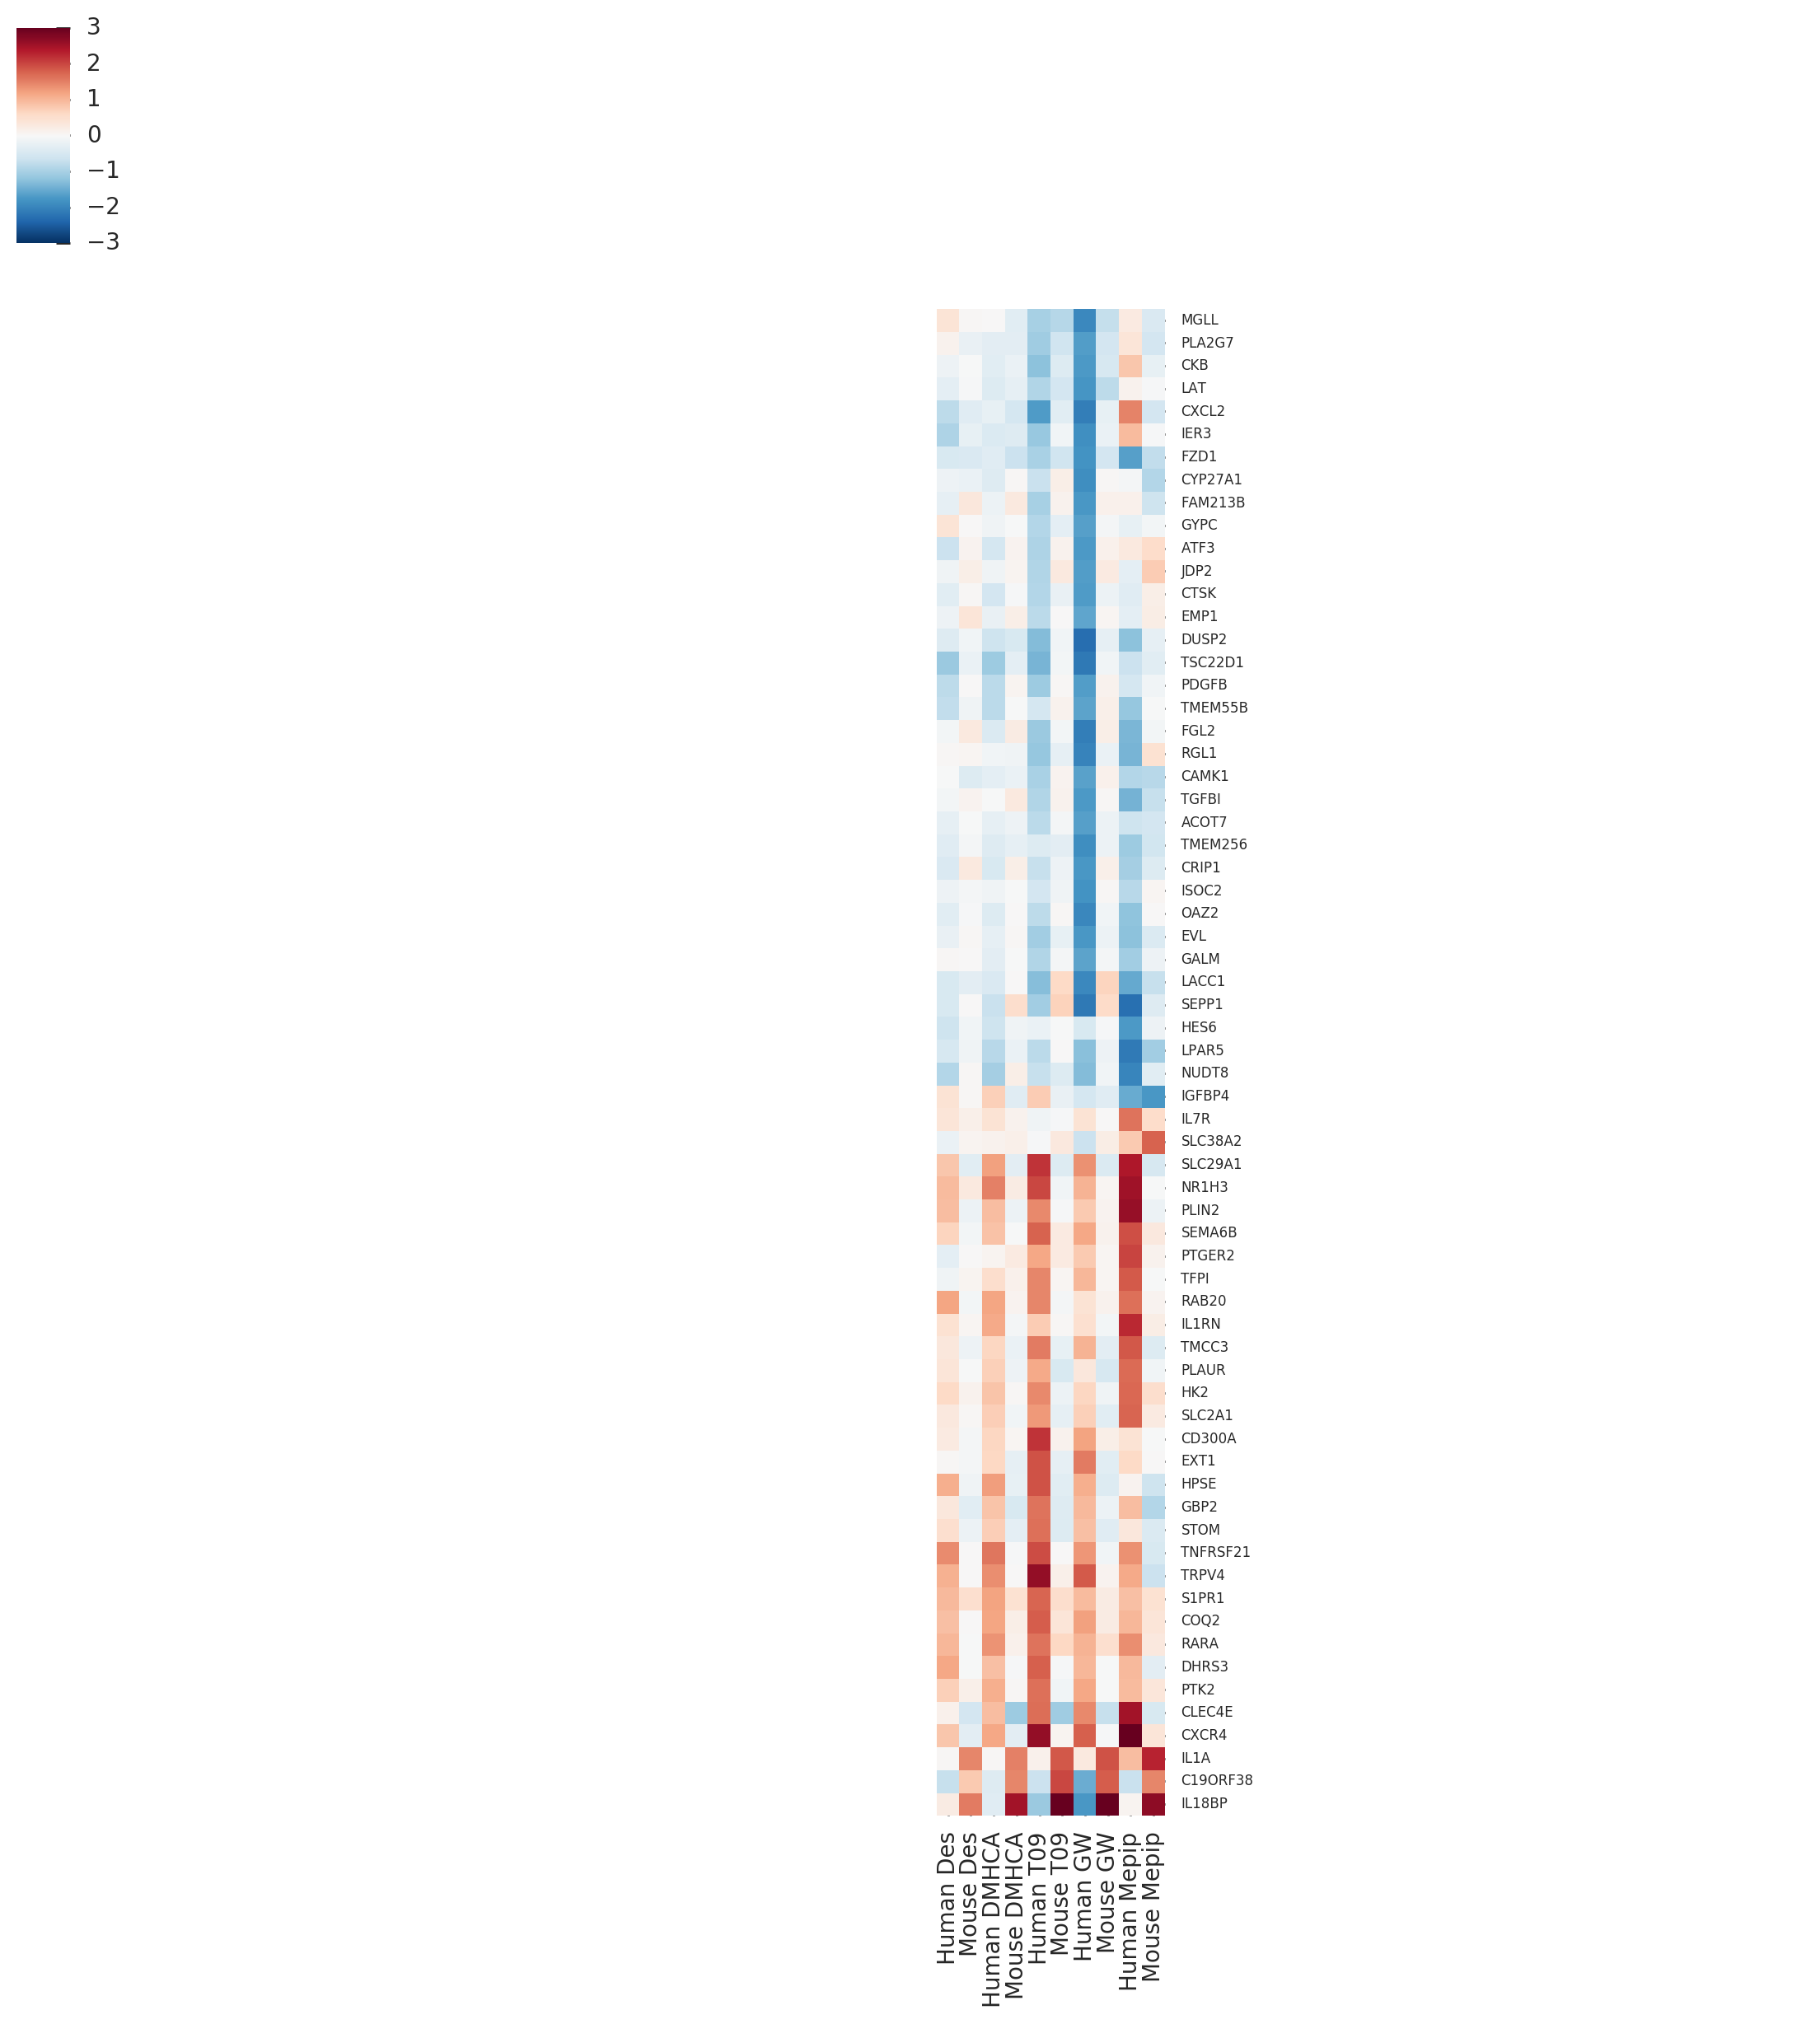

In [1889]:


### conditions specific
fold_threshold = np.log2(2)
differential_genes = set()
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    mouse_genes_up = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    mouse_genes_down = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    
    mouse_genes = mouse_genes_up.union(mouse_genes_down)
    
    human_genes_up_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_matched = human_genes_up_matched.union(human_genes_down_matched)

    human_genes_up_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_pooled = human_genes_up_pooled.union(human_genes_down_pooled)
    
    mouse_specific_genes = mouse_genes - human_genes_matched
    human_specific_genes = human_genes_matched - mouse_genes
    differential_genes = differential_genes.union(mouse_specific_genes)
    differential_genes = differential_genes.union(human_specific_genes)

human_data = foldChange_human_frame[foldChange_human_frame.index.isin(differential_genes)]
mouse_data = foldChange_mouse_frame[foldChange_mouse_frame.index.isin(differential_genes)]
# human_data = foldChange_human_frame[foldChange_human_frame.index.isin(chris_genes)]
# mouse_data = foldChange_mouse_frame[foldChange_mouse_frame.index.isin(chris_genes)]


# average mouse data
averaged_mouse_data = mouse_data[[]]
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    averaged_mouse_data['Mouse '+ treatment ] = mouse_data[[x for x in mouse_data.columns.values if treatment in x]].mean(axis=1)
# average human data
averaged_human_data = human_data[[]]
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    averaged_human_data['Human '+ treatment ] = human_data[[x for x in human_data.columns.values if treatment in x]].mean(axis=1)


    
print(averaged_human_data.shape, averaged_mouse_data.shape)
data=pd.concat([averaged_mouse_data, averaged_human_data], axis=1)
# reorder columns
columns = []
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    columns.append('Human '+treatment)
    columns.append('Mouse '+treatment)
data = data[columns]
# data = data.ix[chris_genes,:]
# print(data.shape)
# # filter by fold change
data = data[data.abs().max(axis=1) >= fold_threshold]
print(data.shape)
with sns.axes_style('ticks',{'ytick.direction':'in', 'xtick.direction':'in'}):
    cg = sns.clustermap(data,
                        figsize=(14,14),
                        vmin=-3,
                        vmax=3,
                       col_cluster=False,
                        row_cluster=False,
                       square=True)

    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, size=6);
    plt.savefig('human_mouse_differential_ortholog_heatmap_paired.pdf',bbox_inches='tight')

(265, 5) (265, 5)
(265, 10)
(31, 10)


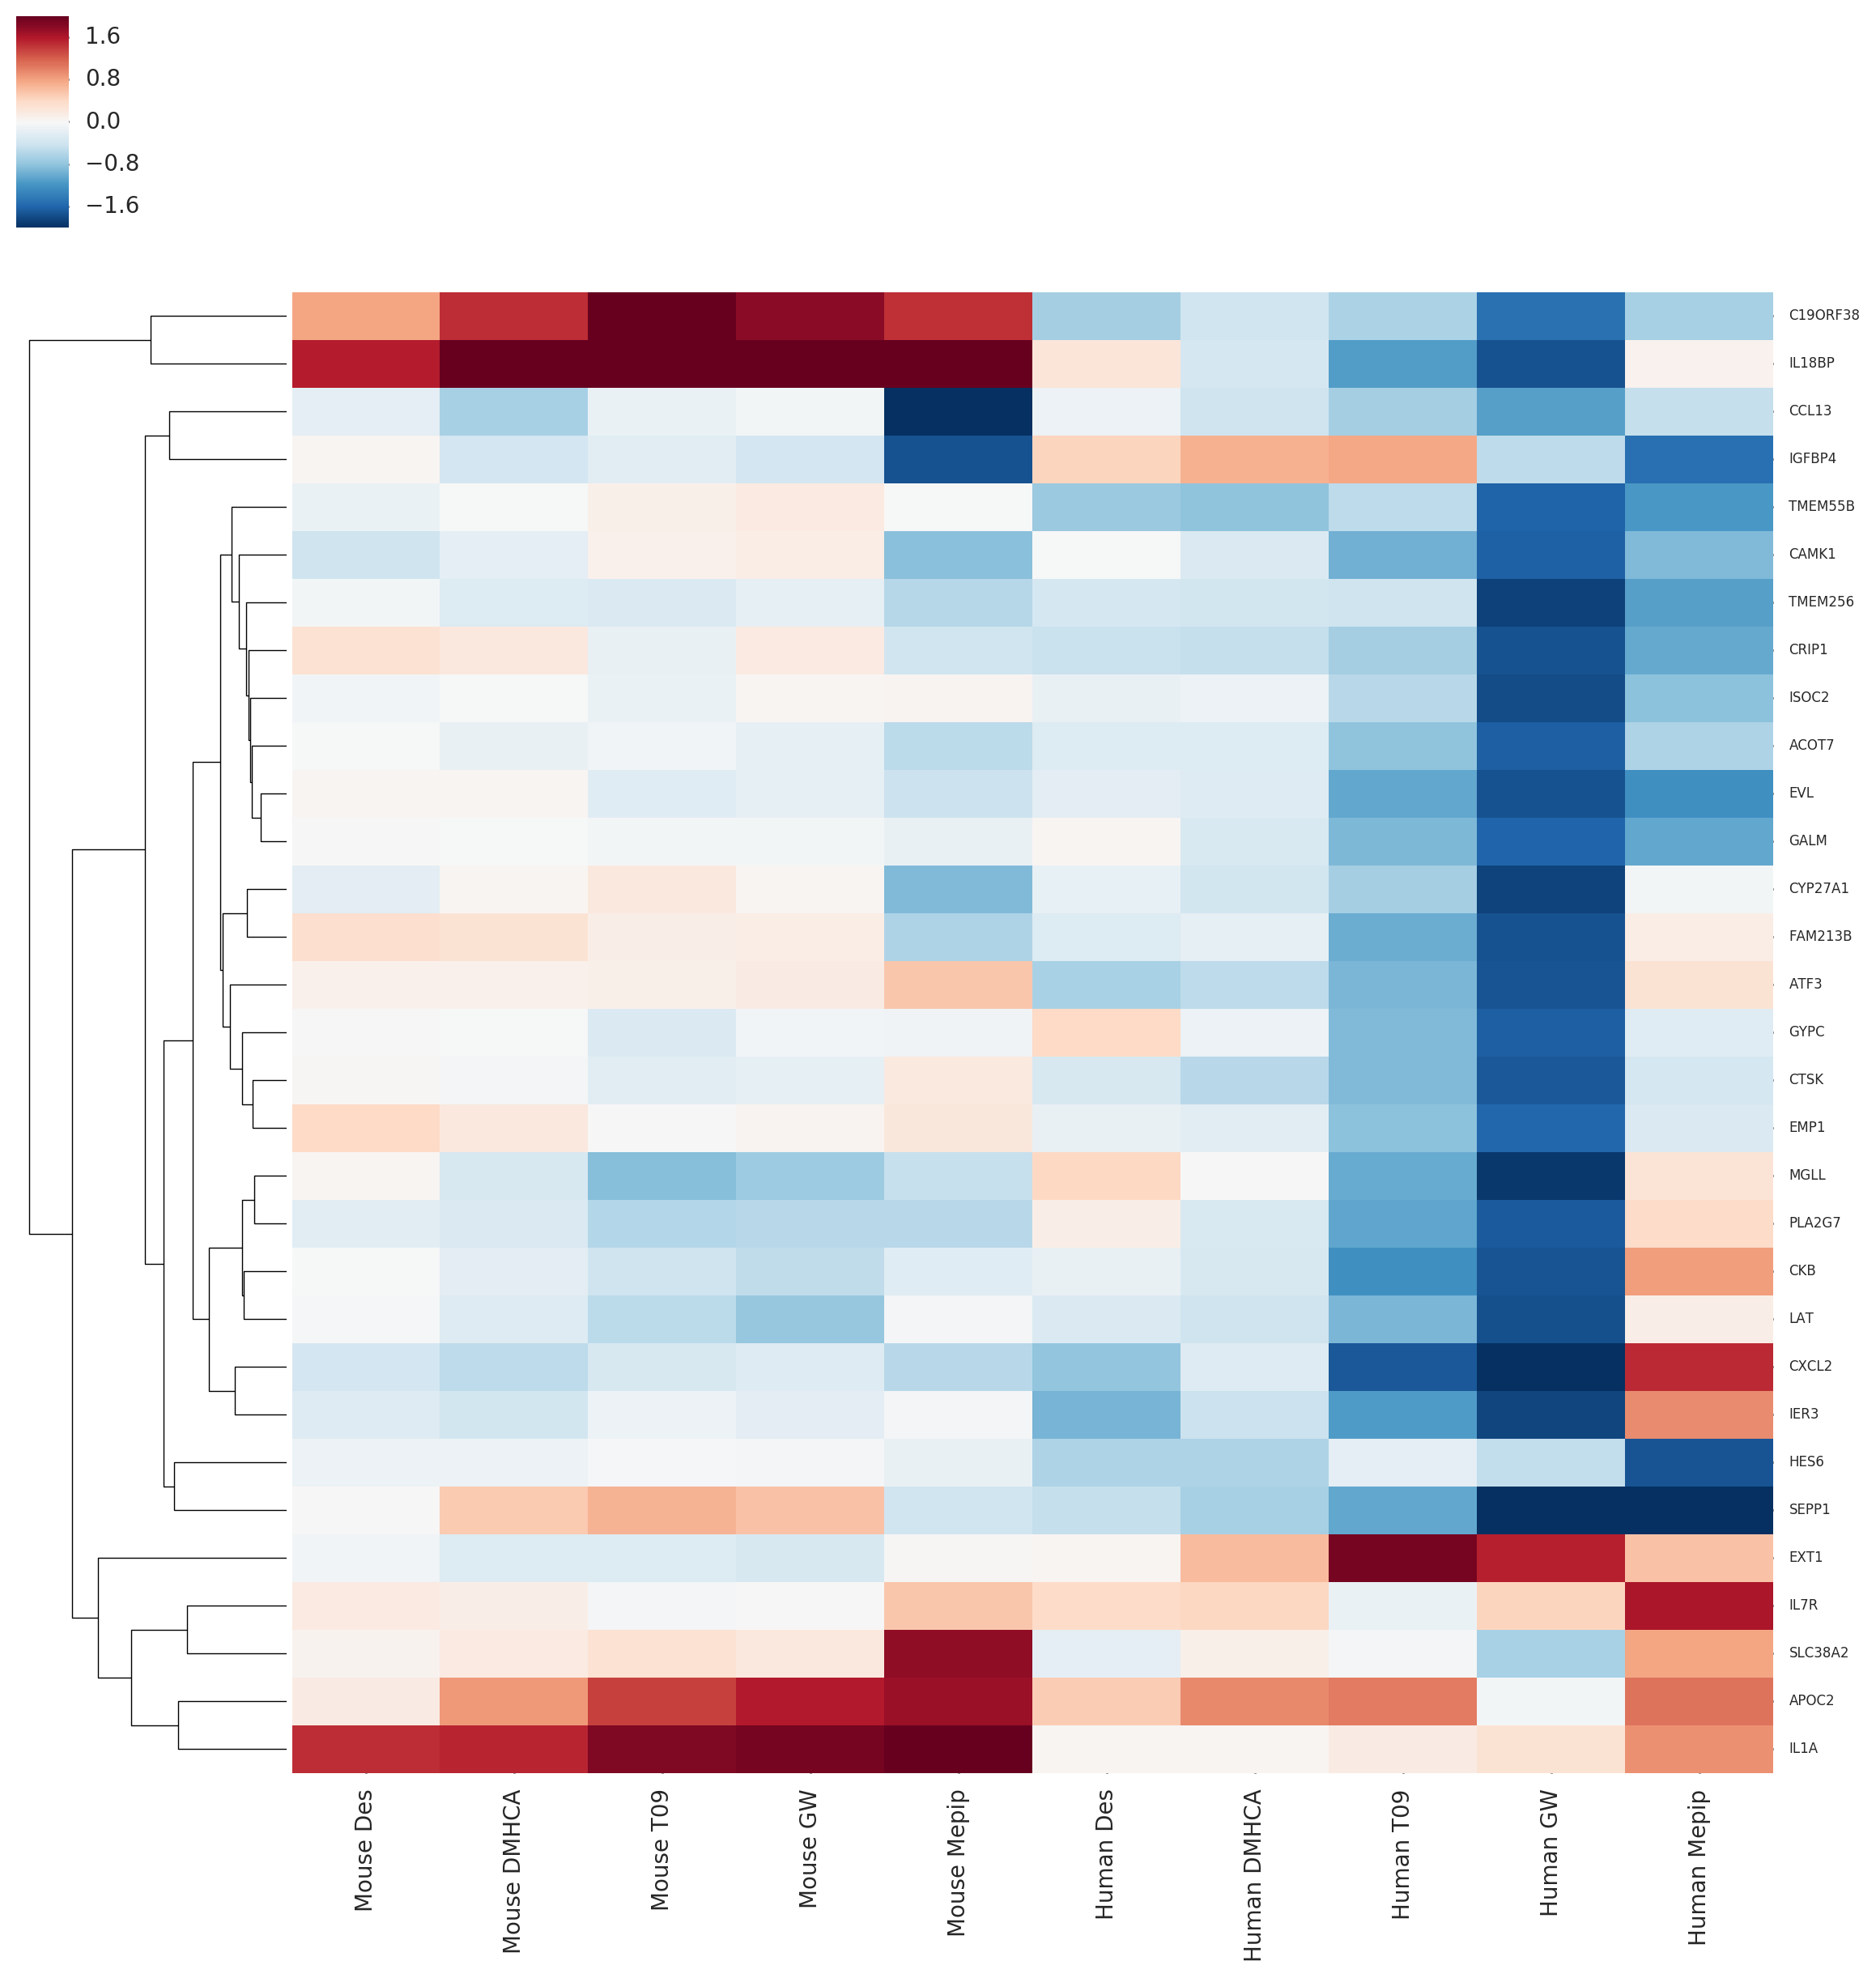

In [1845]:
### overall
fold_threshold = np.log2(3)
differential_genes = set()
mouse_genes = set()
human_genes = set()
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    mouse_genes_up = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    mouse_genes_down = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']).intersection(intersecting_genes)
            
    human_genes_up_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    
#     human_genes_up_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_up']).intersection(intersecting_genes)
#     human_genes_down_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_down']).intersection(intersecting_genes)
#     human_genes_pooled = human_genes_up_pooled.union(human_genes_down_pooled)

    # add genes to overall set of diff genes
    mouse_genes = mouse_genes.union(mouse_genes_up)
    mouse_genes = mouse_genes.union(mouse_genes_down)
    
    human_genes = human_genes.union(human_genes_up_matched)
    human_genes = human_genes.union(human_genes_down_matched)
    
        
mouse_specific_genes = mouse_genes - human_genes
human_specific_genes = human_genes - mouse_genes
differential_genes = differential_genes.union(mouse_specific_genes)
differential_genes = differential_genes.union(human_specific_genes)

human_data = foldChange_human_frame[foldChange_human_frame.index.isin(differential_genes)]
mouse_data = foldChange_mouse_frame[foldChange_mouse_frame.index.isin(differential_genes)]
# average mouse data
averaged_mouse_data = mouse_data[[]]
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    averaged_mouse_data['Mouse '+ treatment ] = mouse_data[[x for x in mouse_data.columns.values if treatment in x]].mean(axis=1)
# average human data
averaged_human_data = human_data[[]]
for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
    averaged_human_data['Human '+ treatment ] = human_data[[x for x in human_data.columns.values if treatment in x]].mean(axis=1)


    
print(averaged_human_data.shape, averaged_mouse_data.shape)
data=pd.concat([averaged_mouse_data, averaged_human_data], axis=1)
# reorder columns
# columns = []
# for treatment in ['Des', 'DMHCA', 'T09', 'GW', 'Mepip']:
#     columns.append('Human '+treatment)
#     columns.append('Mouse '+treatment)
# data = data[columns]

print(data.shape)
# filter by fold change
data = data[data.abs().max(axis=1) > fold_threshold]
print(data.shape)
with sns.axes_style('ticks',{'ytick.direction':'in', 'xtick.direction':'in'}):
    cg = sns.clustermap(data,
                        figsize=(14,14),
                        vmin=-2,
                        vmax=2,
                       col_cluster=False)

    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, size=6);
    plt.savefig('human_mouse_differential_ortholog_heatmap_overall.pdf',bbox_inches='tight')

In [ ]:
### save rpkm values from heatmap
fold_threshold = 1
differential_genes = set()
for treatment in ['Des', 'DMHCA', 'T09']:
    mouse_genes_up = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    mouse_genes_down = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    
    mouse_genes = mouse_genes_up.union(mouse_genes_down)
    
    human_genes_up_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_matched = human_genes_up_matched.union(human_genes_down_matched)

    human_genes_up_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_pooled = human_genes_up_pooled.union(human_genes_down_pooled)
    
    mouse_specific_genes = mouse_genes - human_genes_matched
    human_specific_genes = human_genes_matched - mouse_genes
    differential_genes = differential_genes.union(mouse_specific_genes)
    differential_genes = differential_genes.union(human_specific_genes)

human_data = foldChange_human_frame[foldChange_human_frame.index.isin(differential_genes)]
mouse_data = foldChange_mouse_frame[foldChange_mouse_frame.index.isin(differential_genes)]
# average mouse data
averaged_mouse_data = mouse_data[[]]
for treatment in ['Des', 'DMHCA', 'T09']:
    averaged_mouse_data['Mouse '+ treatment ] = mouse_data[[x for x in mouse_data.columns.values if treatment in x]].mean(axis=1)

print(human_data.shape, averaged_mouse_data.shape)
data=pd.concat([averaged_mouse_data, human_data], axis=1)
print(data.shape)
# filter by fold change
data = data[data.abs().max(axis=1) > fold_threshold]
print(data.shape)

rpkm_human_frame[rpkm_human_frame.index.isin(data.index.values)][columns].to_csv('human_differential_rpkm.tsv', index=False, sep='\t')
rpkm_mouse_frame[rpkm_mouse_frame.index.isin(data.index.values)].to_csv('mouse_differential_rpkm.tsv', index=False, sep='\t')